In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from Modules import fg
from Modules.st import *
from Modules.fg import *
from Modules._AMP_BP_Epi_GLM import *
from Analysis.gen import simulate_one_detSIR_list, generate_contacts, generate_sensors_obs
import networkx as nx
import lzma, pickle
import seaborn as sns
import pandas as pd
import tqdm
from scipy import special

load_Dir = "./data_shared/"
#load_Dir = "./CLUSTER/DataCxtEpi/"

In [2]:
sns.set_theme(style="whitegrid",font_scale=1.3)

In [3]:
N=20000
lam=1

In [67]:
def delta_virtual(c):
    return 0.5 *special.erfc(c/np.sqrt(2))

def c_virtual(delta):
    return np.sqrt(2) * special.erfcinv(2*delta)

## Gaussian $u$

### Old

In [13]:
file_name = "DF_Gaussian_1308.xz"
with lzma.open("./data_shared/"  + file_name, "rb") as f:
    data_frame = pickle.load(f)
#add more points
file_name = "DF_gauss_final-2.xz"
with lzma.open("./data_shared/"  + file_name, "rb") as f:
    data_frame_2 = pickle.load(f)
data_frame_2 = data_frame_2[data_frame_2["c"]==2]
data_frame = pd.concat([data_frame, data_frame_2], ignore_index=True)

In [14]:
data_frame.iloc[:,0:5]

init graph_type    $N$  $d$  $\lambda$
0      rnd        rrg  20000    3        1.0
1      rnd        rrg  20000    3        1.0
2      rnd        rrg  20000    3        1.0
3      rnd        rrg  20000    3        1.0
4      rnd        rrg  20000    3        1.0
...    ...        ...    ...  ...        ...
18775  rnd        rrg  20000    3        1.0
18776  rnd        rrg  20000    3        1.0
18777  rnd        rrg  20000    3        1.0
18778  rnd        rrg  20000    3        1.0
18779  rnd        rrg  20000    3        1.0

[18780 rows x 5 columns]

In [15]:
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\alpha$"] = np.int32(data_frame[r"$N$"]/data_frame[r"$M$"])

In [16]:
data_frame_tot = data_frame.copy()
data_frame = data_frame[data_frame["init"]=="rnd"]
data_frame.iloc[:,0:5]

init graph_type    $N$  $d$  $\lambda$
0      rnd        rrg  20000    3        1.0
1      rnd        rrg  20000    3        1.0
2      rnd        rrg  20000    3        1.0
3      rnd        rrg  20000    3        1.0
4      rnd        rrg  20000    3        1.0
...    ...        ...    ...  ...        ...
18775  rnd        rrg  20000    3        1.0
18776  rnd        rrg  20000    3        1.0
18777  rnd        rrg  20000    3        1.0
18778  rnd        rrg  20000    3        1.0
18779  rnd        rrg  20000    3        1.0

[11220 rows x 5 columns]

#### Single $c$

In [17]:
datacm1 = data_frame[(data_frame["c"] == -1) & (data_frame[r"$\alpha$"] < 50)]
datac0 = data_frame[(data_frame["c"] == 0) & (data_frame[r"$\alpha$"] < 50)]
datac1 = data_frame[(data_frame["c"] == 1) & (data_frame[r"$\alpha$"] < 50)]
datac2 = data_frame[(data_frame["c"] == 2) & (data_frame[r"$\alpha$"] < 50)]

<Axes: xlabel='$\\rho$', ylabel='$\\widetilde{MO}_{t=0}$'>

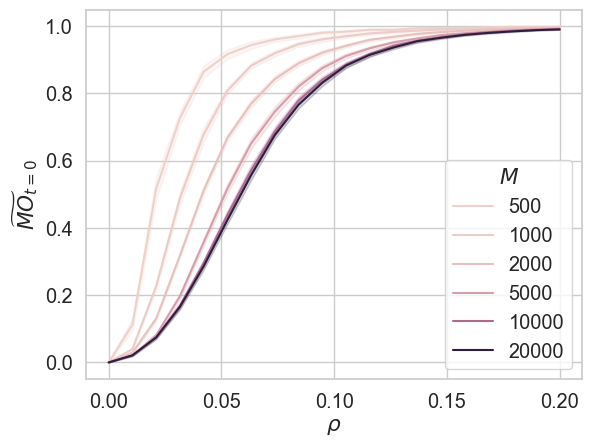

In [18]:
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datac2,x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$M$")

#### Together

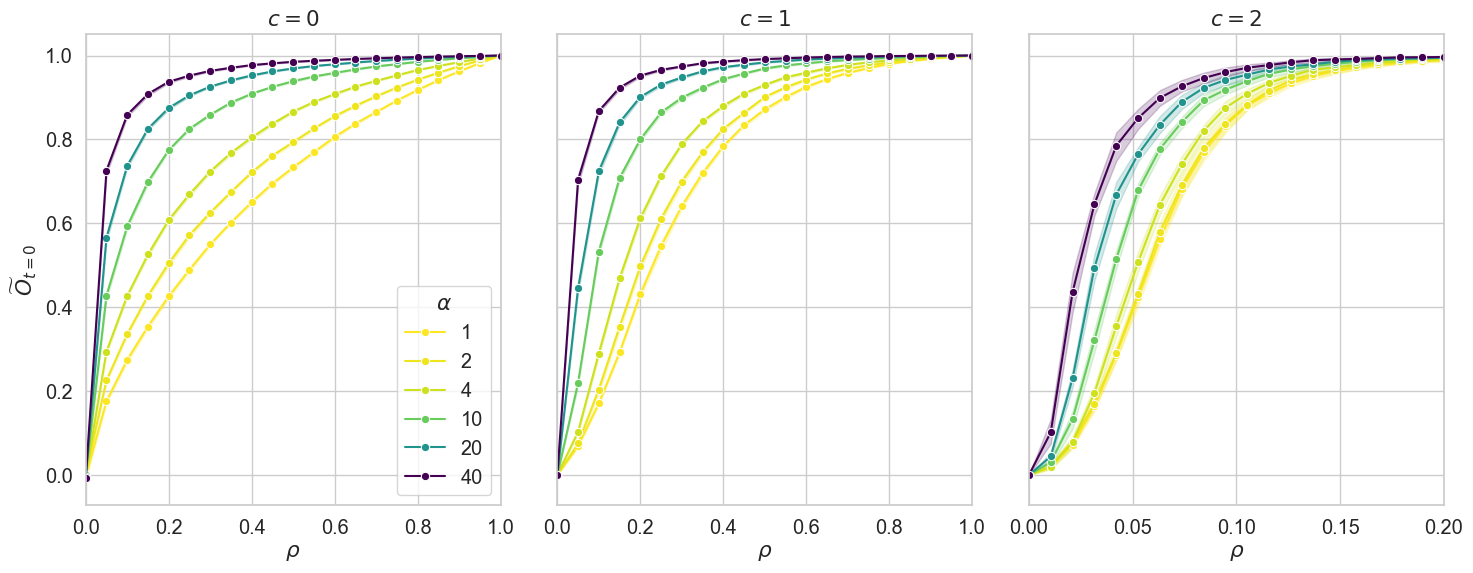

In [19]:
#Put all three previous plots side by side in a single figure
x_s= r"$\rho$"
y_s = r"$\widetilde{O}_{t=0}$"#r'$R_{MSE}$'#r"$\widetilde{MO}_{t=0}$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Gaussian $\omega$, $N={N}$, $\lambda={lam}$")
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[0],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[1],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac2,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=0$")
axs[1].set_title(r"$c=1$")
axs[2].set_title(r"$c=2$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,0.2)
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/SI_Gaussian_omega_N{N}_lam{lam}.pdf")

### With BP

In [20]:
file_name = "DF_BP_1308.xz"
with lzma.open("./data_shared/"  + file_name, "rb") as f:
    data_frame_BP = pickle.load(f)

load_Dir = "./CLUSTER/DataCxtEpi/data_new/"
file_name = "DF_20250616-c2BP.xz"
with lzma.open(load_Dir  + file_name, "rb") as f:
    data_frame_BP2 = pickle.load(f)

In [21]:
data_frame_BP[r"$\rho$"] = data_frame_BP["M"]
data_frame_BP[r"$\delta$"] = data_frame_BP["S"]
data_frame_BP2[r"$\rho$"] = data_frame_BP2["M"]
data_frame_BP2[r"$\delta$"] = data_frame_BP2["S"]

In [22]:
0.5*(1 - special.erf(2/np.sqrt(2)))

np.float64(0.02275013194817921)

In [23]:
data_frame_BP.iloc[:5,30:45]

it_final         logL  $O_{t=0}$  $O_{t=0,RND}$  $MO_{t=0}$  \
0        16 -7867.318732    0.97915        0.84140    0.979372   
1        15 -7867.318732    0.97915        0.84140    0.979374   
2        15 -7939.034900    0.98000        0.84055    0.981270   
3        13 -7939.034900    0.98000        0.84055    0.981271   
4        16 -7974.815393    0.97880        0.83800    0.980231   

   $MO_{t=0,RND}$  $\delta O_{t=0}$  $\widetilde{O}_{t=0}$  \
0        0.842488         -0.000222               0.868537   
1        0.842490         -0.000224               0.868537   
2        0.841882         -0.001270               0.874569   
3        0.841883         -0.001271               0.874569   
4        0.839737         -0.001431               0.869136   

   $\widetilde{MO}_{t=0}$  $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  \
0                0.869039                     -0.000502        1.0   
1                0.869050                     -0.000513        1.0   
2                0.881542                     -0.006973        1.0   
3                0.881549                     -0.006981        1.0   
4                0.876649                     -0.007514        1.0   

   $O_{t=T,RND}$  $MO_{t=T}$  $MO_{t=T,RND}$  $\delta O_{t=T}$  
0            1.0         1.0             1.0               0.0  
1            1.0         1.0             1.0               0.0  
2            1.0         1.0             1.0               0.0  
3            1.0         1.0             1.0               0.0  
4            1.0         1.0             1.0               0.0

Delta: 0.5 0.158655 (c=1) 0.841345 (c=-1)

In [24]:
dataBPcm1 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.841345)& (data_frame_BP["init"] == "rnd")]
dataBPc0 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.5)& (data_frame_BP["init"] == "rnd")]
dataBPc1 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.158655)& (data_frame_BP["init"] == "rnd")]

Choose the observable:

In [25]:
#y_s = '$MO_{t=0}$'
#y_s = 'MSE'
#y_s = r'$R_{MSE}$'
y_s = r"$\widetilde{O}_{t=0}$"

Plot:

In [26]:
dataBPcm2 = data_frame_BP2[(data_frame_BP2["init"] == "rnd")]
rho_list = np.sort(data_frame_BP[r"$\rho$"].unique())
rho_list2 = np.sort(data_frame_BP2[r"$\rho$"].unique())
rMO_m1 = np.zeros(len(rho_list))
rMO_0 = np.zeros(len(rho_list))
rMO_1 = np.zeros(len(rho_list))
rMO_2 = np.zeros(len(rho_list2))
for i,rho in enumerate(rho_list):
    rMO_m1[i] = dataBPcm1[dataBPcm1[r"$\rho$"] == rho][y_s].mean()
    rMO_0[i] = dataBPc0[dataBPc0[r"$\rho$"] == rho][y_s].mean()
    rMO_1[i] = dataBPc1[dataBPc1[r"$\rho$"] == rho][y_s].mean()
for i,rho in enumerate(rho_list2):
    rMO_2[i] = dataBPcm2[dataBPcm2[r"$\rho$"] == rho][y_s].mean()

In [27]:
palette = sns.color_palette("viridis",8)[1:7]
palette

[(0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476)]

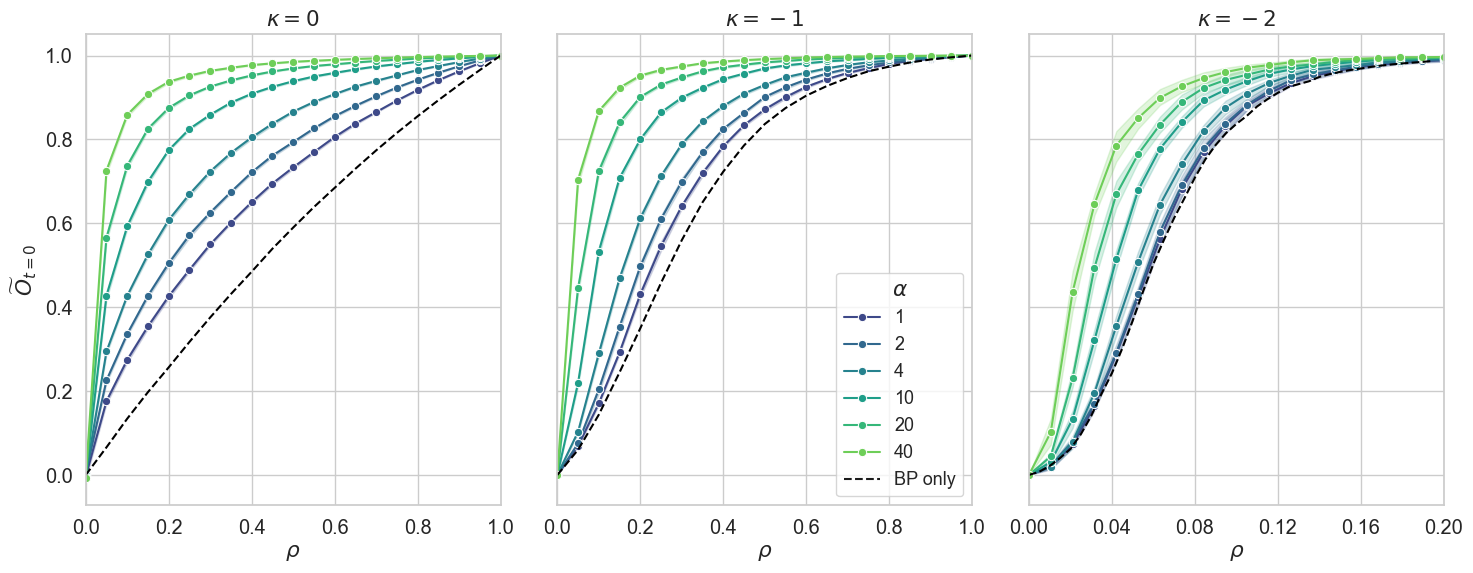

In [28]:

#Add BP curves to the previous plot
x_s= r"$\rho$"
hue_s = r"$\alpha$"
y_s = "$\widetilde{O}_{t=0}$"
#y_s = r'$R_{SE}$'
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[0],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend=None)
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac2,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend=None)
axs[0].set_title(r"$\kappa=0$")
axs[1].set_title(r"$\kappa=-1$")
axs[2].set_title(r"$\kappa=-2$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,0.2)
axs[0].plot(rho_list, rMO_0, color="black", linestyle="--")
axs[1].plot(rho_list, rMO_1, color="black", linestyle="--")
axs[2].plot(rho_list2, rMO_2, color="black", linestyle="--")
# Add second legend for BP curves without substituting the first legend
line_bp = Line2D([0], [0], label='BP only', color='k', linestyle='--')
#handles, labels = axs[0].get_legend_handles_labels()
#handles.append(line_bp)
#labels.append('BP only')
#axs[0].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

handles, labels = axs[1].get_legend_handles_labels()
handles.append(line_bp)
labels.append('BP only')
axs[1].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

#handles, labels = axs[2].get_legend_handles_labels()
#handles.append(line_bp)
#labels.append('BP only')
#axs[2].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")
axs[2].set_xticks([0,0.04,0.08,0.12,0.16,0.2])
plt.tight_layout()
plt.show()
fig.savefig(f"./figures/O_SI_Gaussian_k2_BP.pdf")#,dpi=600)

In [29]:
y_s = r'$R_{SE}$'

In [30]:
dataBPcm2 = data_frame_BP2[(data_frame_BP2["init"] == "rnd")]
rho_list = np.sort(data_frame_BP[r"$\rho$"].unique())
rho_list2 = np.sort(data_frame_BP2[r"$\rho$"].unique())
rMO_m1 = np.zeros(len(rho_list))
rMO_0 = np.zeros(len(rho_list))
rMO_1 = np.zeros(len(rho_list))
rMO_2 = np.zeros(len(rho_list2))
for i,rho in enumerate(rho_list):
    rMO_m1[i] = dataBPcm1[dataBPcm1[r"$\rho$"] == rho][y_s].mean()
    rMO_0[i] = dataBPc0[dataBPc0[r"$\rho$"] == rho][y_s].mean()
    rMO_1[i] = dataBPc1[dataBPc1[r"$\rho$"] == rho][y_s].mean()
for i,rho in enumerate(rho_list2):
    rMO_2[i] = dataBPcm2[dataBPcm2[r"$\rho$"] == rho][y_s].mean()

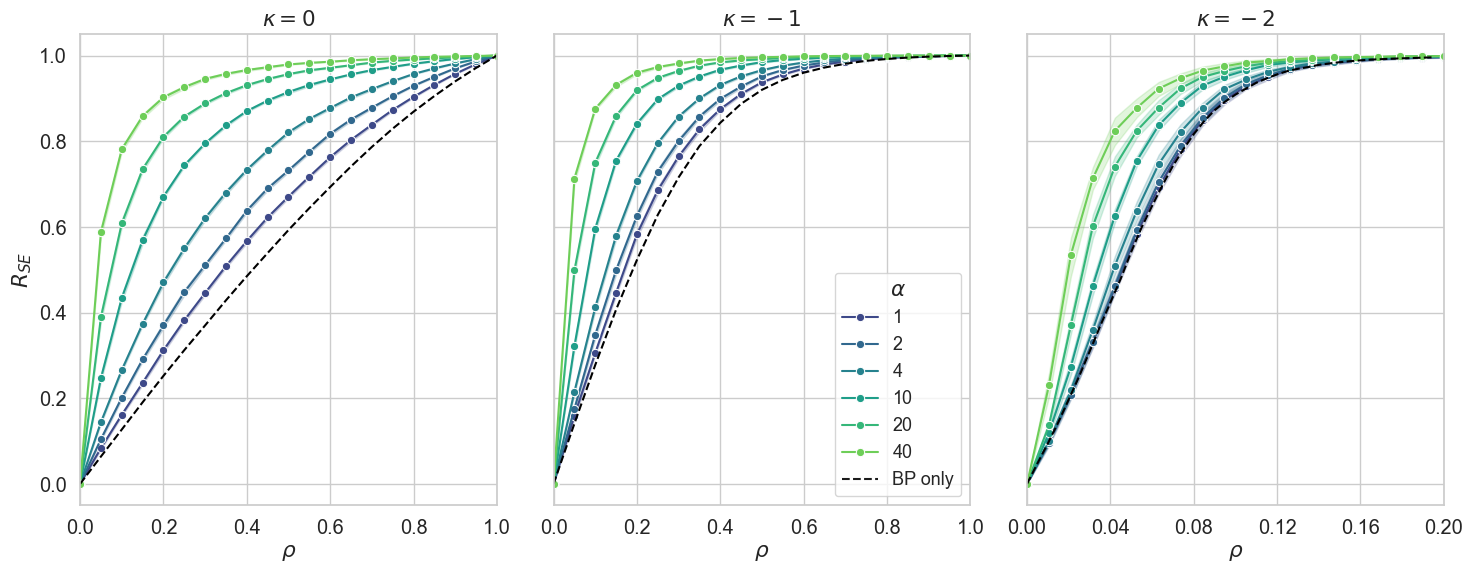

In [32]:
#Add BP curves to the previous plot
x_s= r"$\rho$"
hue_s = r"$\alpha$"
#y_s = "$\widetilde{O}_{t=0}$"
y_s = r'$R_{SE}$'
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[0],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend=None)
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac2,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend=None)
axs[0].set_title(r"$\kappa=0$")
axs[1].set_title(r"$\kappa=-1$")
axs[2].set_title(r"$\kappa=-2$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,0.2)
axs[0].plot(rho_list, rMO_0, color="black", linestyle="--")
axs[1].plot(rho_list, rMO_1, color="black", linestyle="--")
axs[2].plot(rho_list2, rMO_2, color="black", linestyle="--")
# Add second legend for BP curves without substituting the first legend
line_bp = Line2D([0], [0], label='BP only', color='k', linestyle='--')
#handles, labels = axs[0].get_legend_handles_labels()
#handles.append(line_bp)
#labels.append('BP only')
#axs[0].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

handles, labels = axs[1].get_legend_handles_labels()
handles.append(line_bp)
labels.append('BP only')
axs[1].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

#handles, labels = axs[2].get_legend_handles_labels()
#handles.append(line_bp)
#labels.append('BP only')
#axs[2].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")
axs[2].set_xticks([0,0.04,0.08,0.12,0.16,0.2])
plt.tight_layout()
plt.show()
fig.savefig(f"./figures/SE_SI_Gaussian_k2_BP.pdf")#,dpi=600)

##### Nishimori Check

In [178]:
#y_s = "$\widetilde{\delta O}_{t=0}$"
y_s = '$\delta R_{SE}$'

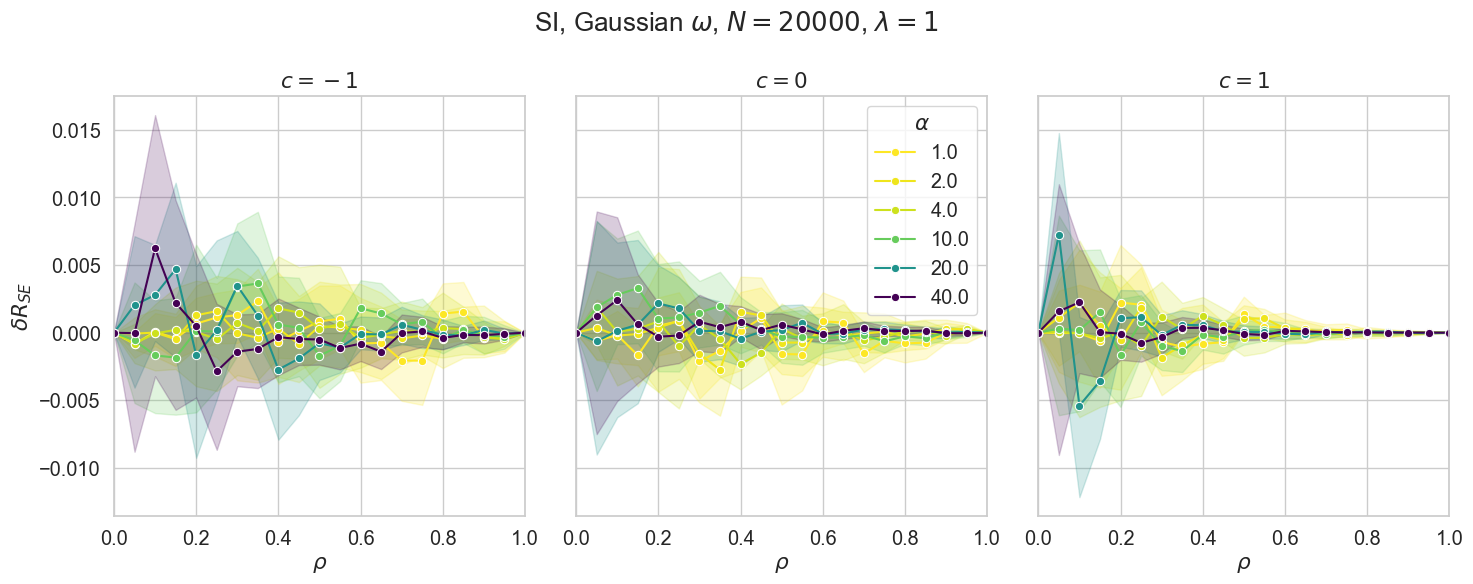

In [179]:
x_s= r"$\rho$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Gaussian $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

##### Inf vs Rnd Check

In [180]:
datacm1tot = data_frame_tot[(data_frame_tot["c"] == -1) & (data_frame_tot[r"$\alpha$"] < 50)]
datac0tot = data_frame_tot[(data_frame_tot["c"] == 0) & (data_frame_tot[r"$\alpha$"] < 50)]
datac1tot = data_frame_tot[(data_frame_tot["c"] == 1) & (data_frame_tot[r"$\alpha$"] < 50)]

In [190]:
alpha = 40
y_s = r"$\widetilde{MO}_{t=0}$"

In [191]:
datacm1tot["init"].unique()

array(['rnd', 'inf'], dtype=object)

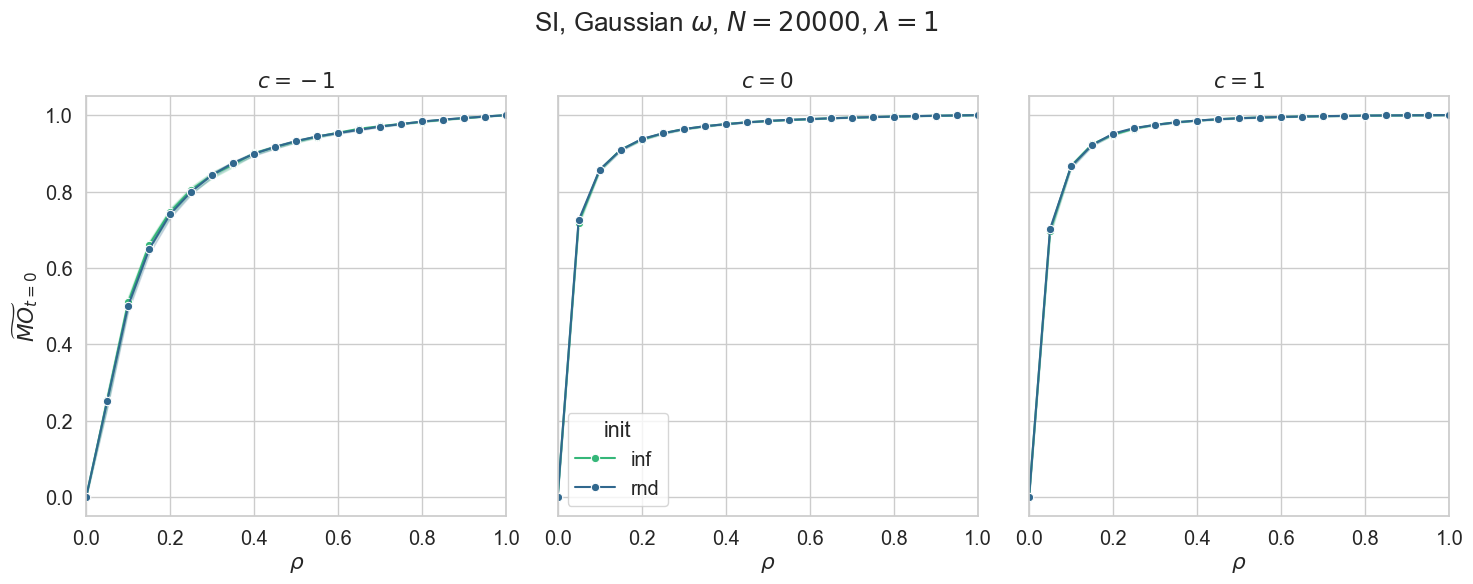

In [192]:
x_s= r"$\rho$"
hue_s = "init"

fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Gaussian $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1tot[datacm1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0tot[datac0tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")   
sns.lineplot(data=datac1tot[datac1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

### Ensemble

In [474]:
file_name = "DF_ensemble.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [475]:
data_frame.iloc[:5,0:15]

init graph_type    $N$  $d$  $\lambda$ s_type    S o_type      M  \
0  rnd        rrg  20000    5        1.0  delta  0.5    rho  0.000   
1  rnd        rrg  20000    5        1.0  delta  0.5    rho  0.000   
2  rnd        rrg  20000    5        1.0  delta  0.5    rho  0.875   
3  rnd        rrg  20000    5        1.0  delta  0.5    rho  0.875   
4  rnd        rrg  20000    3        1.0  delta  0.5    rho  0.625   

   iter_space  seed      tol  n_iter obs_type  snap_time  
0         100     7  0.00001     100  sensors         -1  
1         100     7  0.00001     100  sensors         -1  
2         100    10  0.00001     100  sensors         -1  
3         100    10  0.00001     100  sensors         -1  
4         100     3  0.00001     100  sensors         -1

In [476]:
data_frame["c"].unique()

array([-1.,  0.,  1.])

In [477]:
sns.set_theme(style="whitegrid",font_scale=1.3)

<Axes: xlabel='$\\rho$', ylabel='$\\widetilde{O}_{t=0}$'>

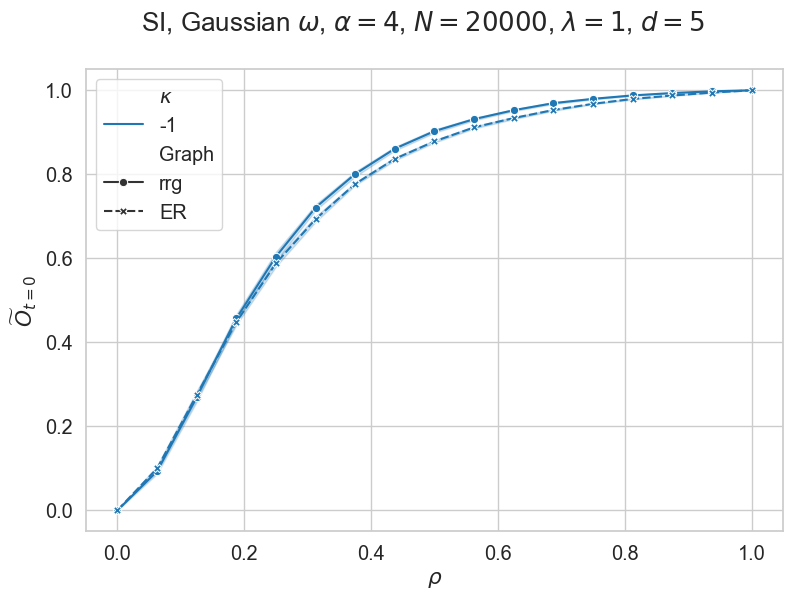

In [478]:
df = data_frame[data_frame[r"$d$"]==5].copy()
df["Graph"] = df["graph_type"]
df[r"$\kappa$"] = -df["c"].astype(int)

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(f"SI, Gaussian $\omega$, $\\alpha=4$, $N=20000$, $\lambda=1$, $d=5$")
sns.lineplot(data=df[df["c"]==1], x=r"$\rho$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\kappa$", markers=True, errorbar=("ci", 99), style="Graph", palette="tab10")

In [483]:
#Create new column in df, if "graph" is rrg, then "RRG", else "ER"
df["Graph"] = df["Graph"].apply(lambda x: "RRG" if x == "rrg" else "ER")

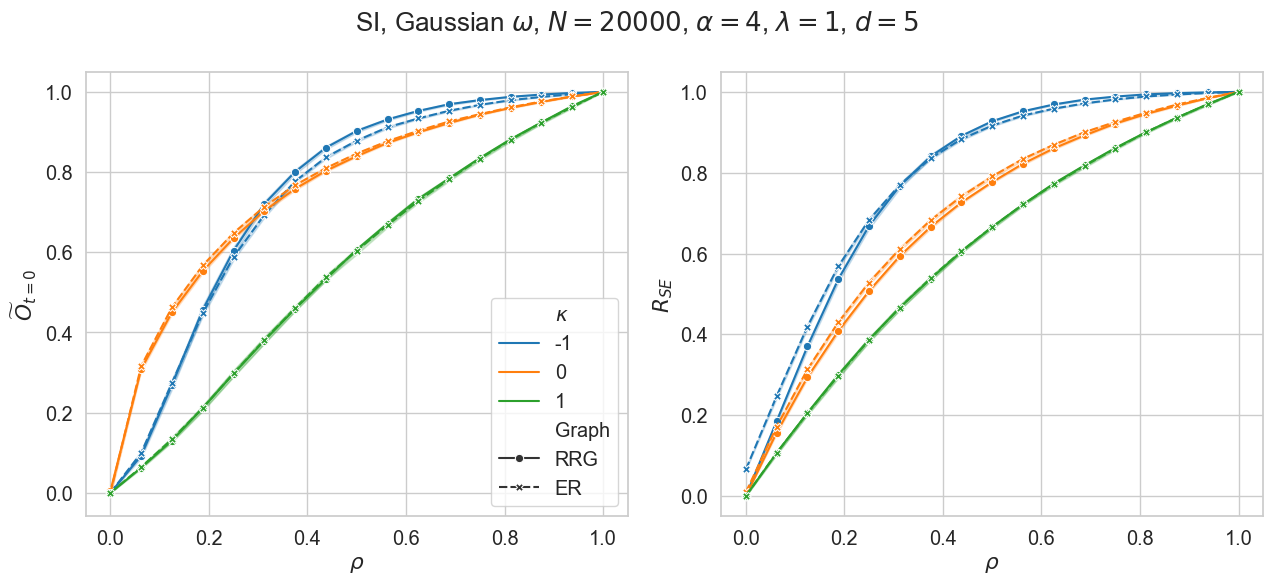

In [485]:
# same plot as before, but 2 x 1 with on the right the MSE 

fig, axs = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle(f"SI, Gaussian $\omega$, $N=20000$, $\\alpha=4$, $\lambda=1$, $d=5$")
sns.lineplot(data=df, x=r"$\rho$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\kappa$", markers=True, errorbar=("ci", 99), style="Graph", palette="tab10", ax=axs[0])
sns.lineplot(data=df, x=r"$\rho$", y=r'$R_{SE}$', hue=r"$\kappa$", markers=True, errorbar=("ci", 99), style="Graph", palette="tab10", ax=axs[1], legend=False)
plt.tight_layout()

#fig.savefig(f"./figures/Plot_ensemble_Gaussian_noT.pdf")


### LogZ

#### SI

In [305]:
file_name = "DF_logZ_SI.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [306]:
data_frame.iloc[:5,-35:-20]

uRad         error  iteration  it_final      logL  $O_{t=0}$  \
0  False  3.755927e-07         11        11 -0.211061    0.89260   
1  False  2.697185e-07         11        11 -0.211744    0.89220   
2  False  9.273248e-07         12        12 -0.388714    0.94860   
3  False  6.720881e-07         13        13 -0.390076    0.94925   
4  False  5.678451e-08          7         7 -0.098873    0.94330   

   $O_{t=0,RND}$  $MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  \
0        0.60400    0.892451        0.604453          0.000149   
1        0.60415    0.891262        0.603563          0.000938   
2        0.77520    0.945619        0.773245          0.002981   
3        0.77160    0.946369        0.771696          0.002881   
4        0.90455    0.942154        0.902495          0.001146   

   $\widetilde{O}_{t=0}$  $\widetilde{MO}_{t=0}$  \
0               0.728788                0.728100   
1               0.727675                0.725711   
2               0.771352                0.760179   
3               0.777802                0.765088   
4               0.405972                0.406744   

   $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  $O_{t=T,RND}$  
0                      0.000687        1.0            1.0  
1                      0.001964        1.0            1.0  
2                      0.011173        1.0            1.0  
3                      0.012714        1.0            1.0  
4                     -0.000772        1.0            1.0

In [307]:
data_frame["c"].unique()

array([-0.25,  0.75, -1.25, -1.  ,  0.  ,  1.25,  1.  ,  2.  , -0.75,
       -1.75, -0.5 ,  0.5 , -1.5 , -2.  ,  0.25,  1.5 ,  1.75])

In [308]:
sns.set_theme(style="whitegrid",font_scale=1.3)

<Axes: xlabel='$\\kappa$', ylabel='$\\frac{1}{N}\\log Z$'>

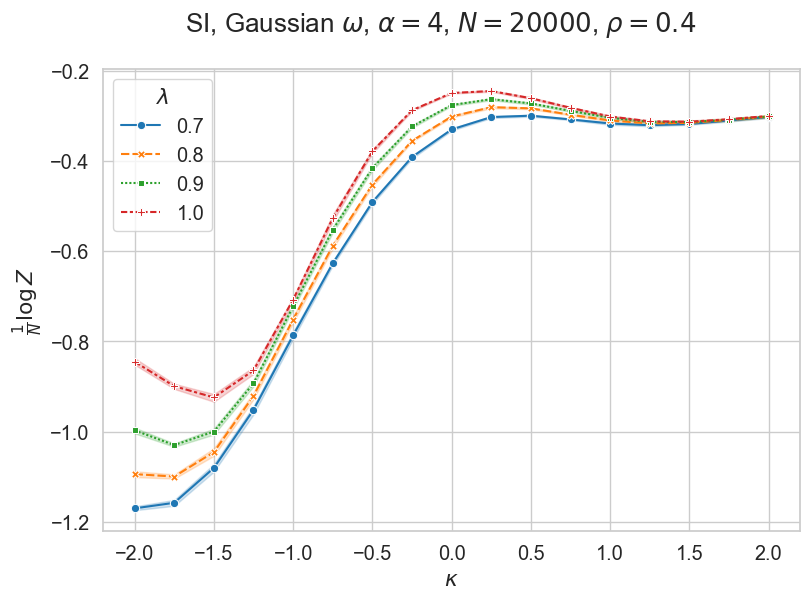

In [309]:
df = data_frame.copy()
df[r"$\kappa$"] = -df["c"]
df[r"$\frac{1}{N}\log Z$"] = df["total_free_entropy"]
df_SI = df

#df_1 = df[(df[r"$\rho$"]==1) & (df[r"$\lambda$"]==1)]
#kappa_list = df_1[r"$\kappa$"].unique()
#kappa_list = np.sort(kappa_list)
#Z_SI_list = np.zeros(len(kappa_list))
#for i,kappa in enumerate(kappa_list):
#    Z_SI_list[i] = df_1[df_1[r"$\kappa$"]==kappa][r"$\frac{1}{N}\log Z$"].mean()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(f"SI, Gaussian $\omega$, $\\alpha=4$, $N=20000$, $\\rho=0.4$")
sns.lineplot(data=df[df[r"$\rho$"]==0.4], x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="tab10")
#plt.plot(kappa_list,Z_SI_list, color="black", linestyle="--", label=r"$\phi_{\rm info}$")

#### dSIR

In [449]:
file_name = "DF_20250502-172723_798.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [450]:
data_frame.iloc[:5,-15:]

$\widetilde{\delta O}_{t=T}$        SE       MSE  $SE_{RND}$  $MSE_{RND}$  \
0                     -0.007897  0.194821  0.187419    0.493614     0.484340   
1                      0.041248  0.198051  0.211713    0.533930     0.550246   
2                      0.004518  3.058011  3.008989    7.202396     7.174415   
3                     -0.028312  3.689927  3.474951    8.082694     7.816002   
4                      0.000000  0.044139  0.044839    0.086905     0.088279   

   $\delta SE$  $R_{SE}$  $R_{MSE}$  $\delta R_{SE}$  \
0     0.007402  0.605317   0.613042        -0.007725   
1    -0.013662  0.629069   0.615239         0.013830   
2     0.049022  0.575418   0.580595        -0.005177   
3     0.214976  0.543478   0.555406        -0.011928   
4    -0.000700  0.492104   0.492081         0.000024   

                                          ConvChecks  free_entropy_BP  \
0  [[10, 0.006952948320501862, 4.841357863633017e...         0.351949   
1  [[10, 0.00816201551286344, 3.880201232139252e-...         0.346131   
2  [[10, 0.011960273558250245, 6.306395439155129e...         0.005381   
3  [[10, 0.013350994979357655, 5.733722055802715e...         0.030887   
4  [[7, 0.002317998761231288, 8.054167975066721e-...         0.412598   

   free_entropy_AMP  total_free_entropy  $\rho$  $\delta$  
0         -0.634164           -0.282215     0.4       0.5  
1         -0.635693           -0.289563     0.4       0.5  
2         -0.699874           -0.694492     0.4       0.5  
3         -0.700191           -0.669305     0.4       0.5  
4         -0.725671           -0.313073     0.4       0.5

In [451]:
data_frame["c"].unique()

array([-0.25,  0.75, -1.25, -1.  ,  0.  ,  1.25,  1.  , -0.75, -1.75,
       -0.5 ,  0.5 , -1.5 , -2.  ,  0.25,  1.5 ,  2.  ,  1.75])

In [452]:
sns.set_theme(style="whitegrid",font_scale=1.3)

<Axes: xlabel='$\\kappa$', ylabel='$\\frac{1}{N}\\log Z$'>

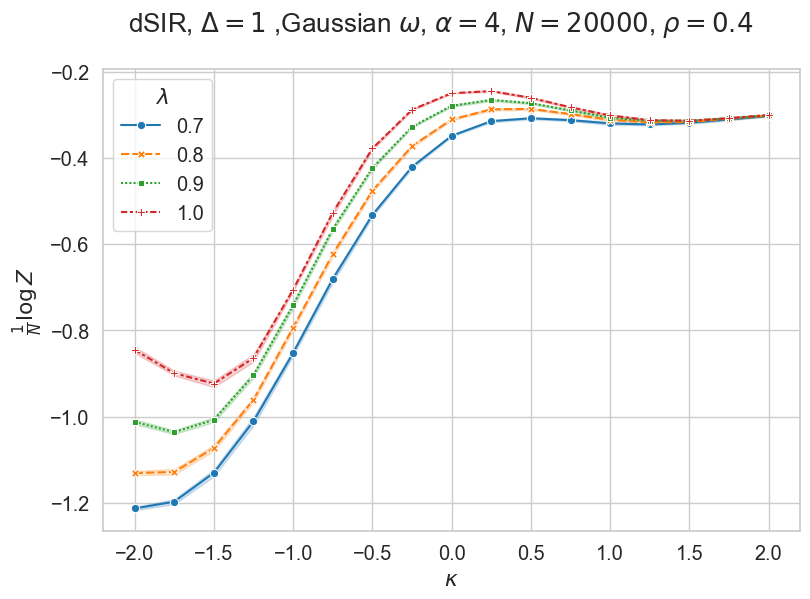

In [455]:
df = data_frame.copy()
df[r"$\kappa$"] = -df["c"]
df[r"$\frac{1}{N}\log Z$"] = df["total_free_entropy"]

df_SIR = df.copy()

#plot
fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(f"dSIR, $\Delta=1$ ,Gaussian $\omega$, $\\alpha=4$, $N=20000$, $\\rho=0.4$")
sns.lineplot(data=df[df[r"$\rho$"]==0.4], x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="tab10")


#### Together

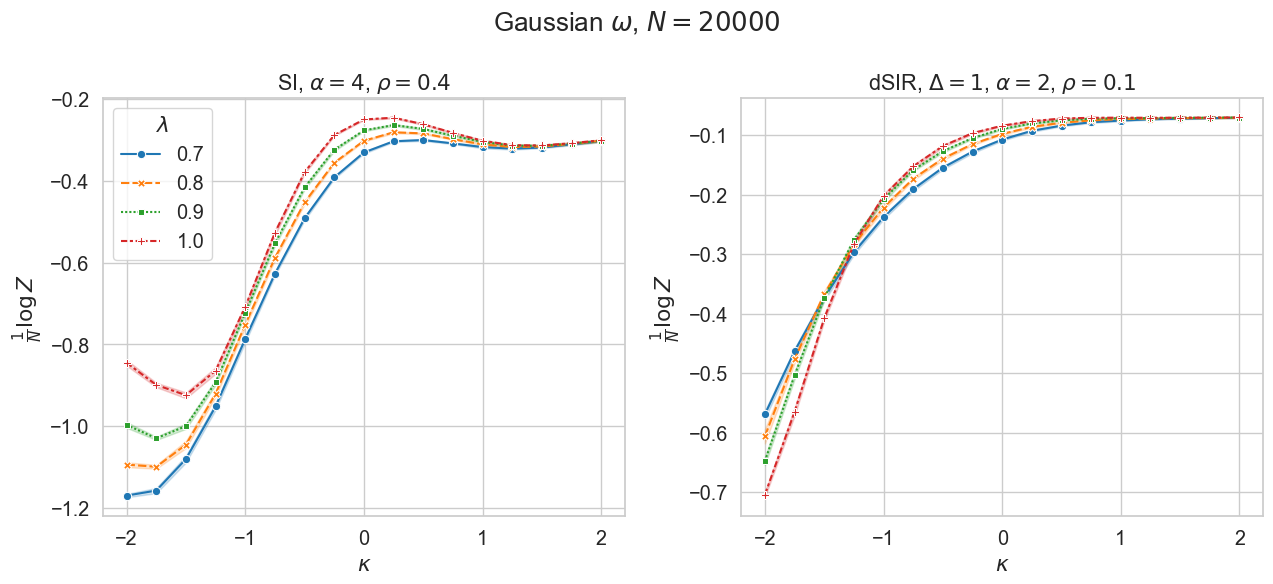

In [316]:
# put the two previous plots side by side

fig, axs = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle(f"Gaussian $\omega$, $N=20000$")

sns.lineplot(data=df_SI[df_SI[r"$\rho$"]==0.4], x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="tab10", ax=axs[0])
sns.lineplot(data=df_SIR[df_SIR[r"$\rho$"]==0.1], x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="tab10", ax=axs[1], legend=False)

axs[0].set_title(r"SI, $\alpha=4$, $\rho=0.4$")
axs[1].set_title(r"dSIR, $\Delta=1$, $\alpha=2$, $\rho=0.1$")

plt.tight_layout()

fig.savefig(f"./figures/Plot_logZ_SI_dSIR.pdf")


#### SI, rho

In [434]:
file_name = "DF_20250502-171223_216.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = round(data_frame["M"],1)
data_frame[r"$\delta$"] = data_frame["S"]

In [435]:
data_frame.iloc[:5,-15:]

$\widetilde{\delta O}_{t=T}$        SE       MSE  $SE_{RND}$  $MSE_{RND}$  \
0                           0.0  0.046018  0.045044    1.256867     1.259304   
1                           0.0  0.039218  0.036852    1.275862     1.274079   
2                           0.0  0.034748  0.037919    1.281260     1.283732   
3                           0.0  0.040843  0.038856    1.297608     1.300519   
4                           0.0  0.061127  0.067670    1.019914     1.017270   

   $\delta SE$  $R_{SE}$  $R_{MSE}$  $\delta R_{SE}$  \
0     0.000974  0.963387   0.964231        -0.000844   
1     0.002366  0.969261   0.971075        -0.001814   
2    -0.003171  0.972880   0.970462         0.002418   
3     0.001987  0.968524   0.970123        -0.001599   
4    -0.006543  0.940067   0.933479         0.006588   

                                          ConvChecks  free_entropy_BP  \
0  [[10, 0.013486230932834187, 7.969193158327859e...         0.070317   
1  [[10, 0.01227220018954256, 5.985952219950102e-...         0.060567   
2  [[10, 0.012036278594231509, 7.658542494484126e...         0.062480   
3  [[10, 0.015316854119864387, 6.335780450740405e...         0.059689   
4  [[10, 0.005273674395786687, 5.650994987832456e...         0.124133   

   free_entropy_AMP  total_free_entropy  $\rho$  $\delta$  
0         -0.915477           -0.845160     0.4       0.5  
1         -0.949085           -0.888519     0.4       0.5  
2         -0.921418           -0.858938     0.4       0.5  
3         -0.927515           -0.867826     0.4       0.5  
4         -0.833590           -0.709457     0.4       0.5

In [436]:
data_frame[r"$\rho$"].unique()

array([0.4, 0.1, 0.2, 0.3, 0.8, 0.7, 0.6, 0. , 0.5, 1. , 0.9])

In [437]:
sns.set_theme(style="whitegrid",font_scale=1.3)

<Axes: xlabel='$\\kappa$', ylabel='$\\frac{1}{N}\\log Z$'>

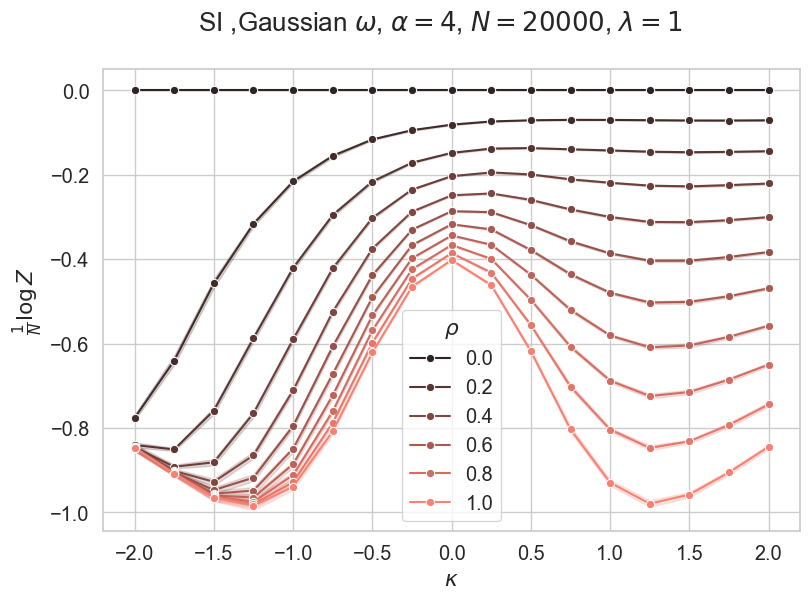

In [446]:
df = data_frame.copy()
df[r"$\kappa$"] = -df["c"]
df[r"$\frac{1}{N}\log Z$"] = df["total_free_entropy"]

df_SI2 = df.copy()

#plot
fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(f"SI ,Gaussian $\omega$, $\\alpha=4$, $N=20000$, $\\lambda=1$")
sns.lineplot(data=df, x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\rho$", marker="o", errorbar=("ci", 99), palette="dark:salmon")


#### Together

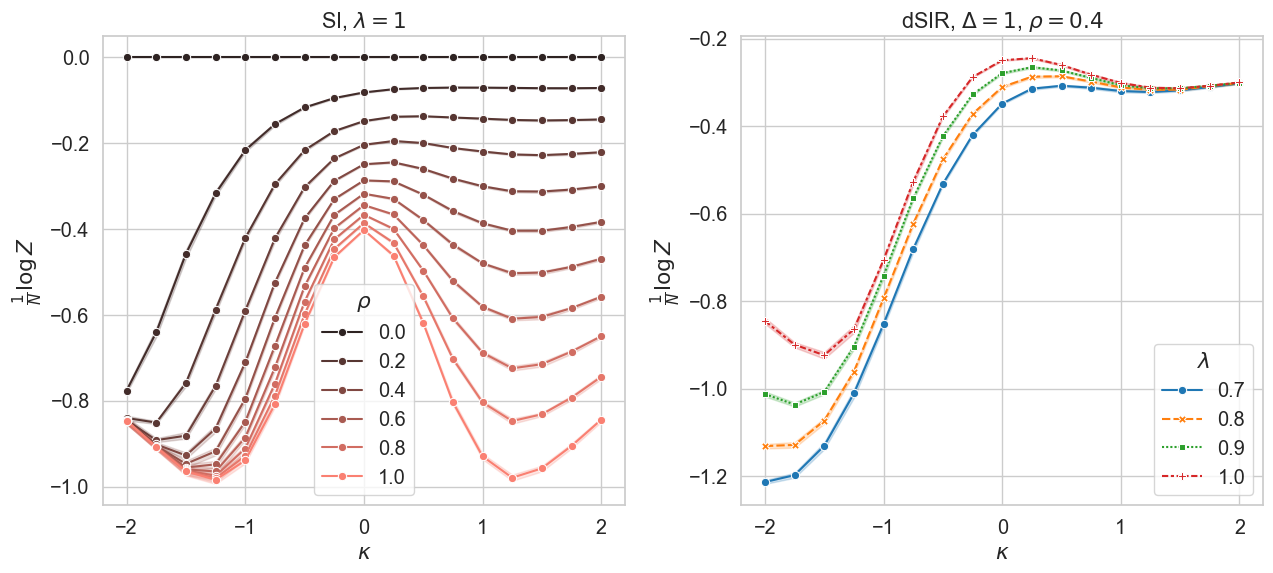

In [459]:
# put the two previous plots side by side

fig, axs = plt.subplots(1, 2, figsize=(13,6))
#fig.suptitle(f"Gaussian $\omega$, $N=20000$")

sns.lineplot(data=df_SI2, x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\rho$", marker="o", errorbar=("ci", 99), palette="dark:salmon", ax=axs[0])
sns.lineplot(data=df_SIR[df_SIR[r"$\rho$"]==0.4], x=r"$\kappa$", y=r"$\frac{1}{N}\log Z$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="tab10", ax=axs[1])

axs[0].set_title(r"SI, $\lambda=1$")
axs[1].set_title(r"dSIR, $\Delta=1$, $\rho=0.4$")
axs[1].legend(title=r"$\lambda$",loc="lower right")
plt.tight_layout()

fig.savefig(f"./figures/Plot_logZ_SI_rho_dSIR_lambda.pdf")


### Nishimori

#### Snap

In [4]:
file_name = "DF_Nishi_snap.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [5]:
data_frame.iloc[:5,37:52]

$MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  $\widetilde{O}_{t=0}$  \
0    0.869382        0.845655         -0.002132               0.146851   
1    0.866341        0.843273          0.004809               0.176151   
2    0.966978        0.830768          0.002822               0.823392   
3    0.969896        0.833070         -0.005396               0.786016   
4    0.909927        0.854088         -0.017527               0.309371   

   $\widetilde{MO}_{t=0}$  $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  \
0                0.153726                     -0.006875        1.0   
1                0.147187                      0.028964        1.0   
2                0.804874                      0.018518        1.0   
3                0.819660                     -0.033644        1.0   
4                0.382690                     -0.073319        1.0   

   $O_{t=T,RND}$  $MO_{t=T}$  $MO_{t=T,RND}$  $\delta O_{t=T}$  \
0            1.0         1.0             1.0               0.0   
1            1.0         1.0             1.0               0.0   
2            1.0         1.0             1.0               0.0   
3            1.0         1.0             1.0               0.0   
4            1.0         1.0             1.0               0.0   

   $\widetilde{O}_{t=T}$  $\widetilde{MO}_{t=T}$  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    0.0                     0.0   
3                    0.0                     0.0   
4                    0.0                     0.0   

   $\widetilde{\delta O}_{t=T}$        SE  
0                           0.0  0.538643  
1                           0.0  0.526942  
2                           0.0  0.138613  
3                           0.0  0.162929  
4                           0.0  0.430270

In [6]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [7]:
data_frame[r"$\lambda$"].unique()

array([1.])

In [8]:
sns.set_theme(style="whitegrid",font_scale=1.3)

[Text(2, 0, '2'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(50, 0, '50')]

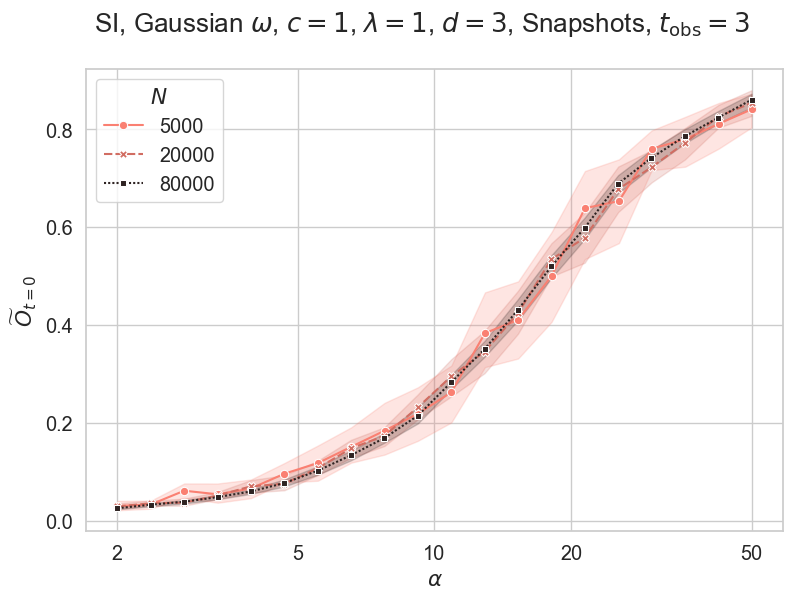

In [9]:
df_snap = data_frame[data_frame["c"]==1].copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $\lambda=1$, $d=3$, Snapshots, $t_{\rm  obs} = 3$ ")
sns.lineplot(data=df_snap, x=r"$\alpha$", y=r"$\widetilde{O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r")
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])

#### Sens

In [10]:
file_name = "DF_Nishi_sens.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [11]:
data_frame.iloc[:5,37:52]

$MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  $\widetilde{O}_{t=0}$  \
0    0.954526        0.837359          0.002724               0.733811   
1    0.957256        0.846533          0.001044               0.726378   
2    0.966350        0.838270          0.001150               0.798762   
3    0.967125        0.846635         -0.000525               0.785554   
4    0.970641        0.837747         -0.000591               0.814723   

   $\widetilde{MO}_{t=0}$  $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  \
0                0.720399                      0.013412        1.0   
1                0.721475                      0.004903        1.0   
2                0.791938                      0.006823        1.0   
3                0.785643                     -0.000089        1.0   
4                0.819056                     -0.004333        1.0   

   $O_{t=T,RND}$  $MO_{t=T}$  $MO_{t=T,RND}$  $\delta O_{t=T}$  \
0            1.0         1.0             1.0      4.123120e-09   
1            1.0         1.0             1.0      7.771561e-16   
2            1.0         1.0             1.0      0.000000e+00   
3            1.0         1.0             1.0      2.231548e-13   
4            1.0         1.0             1.0      0.000000e+00   

   $\widetilde{O}_{t=T}$  $\widetilde{MO}_{t=T}$  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    0.0                     0.0   
3                    0.0                     0.0   
4                    0.0                     0.0   

   $\widetilde{\delta O}_{t=T}$        SE  
0                           0.0  0.224530  
1                           0.0  0.217337  
2                           0.0  0.160445  
3                           0.0  0.173101  
4                           0.0  0.150106

In [12]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [13]:
data_frame[r"$\lambda$"].unique()

array([1.])

In [19]:
sns.set_theme(style="whitegrid",font_scale=1.3)

In [29]:
dummy_ = np.logspace(0, np.log10(50), 20)
print((50000/dummy_).round(0).astype(int))

[50000 40696 33123 26959 21943 17860 14536 11831  9630  7838  6379  5192
  4226  3440  2800  2279  1855  1510  1229  1000]


[Text(2, 0, '2'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(50, 0, '50')]

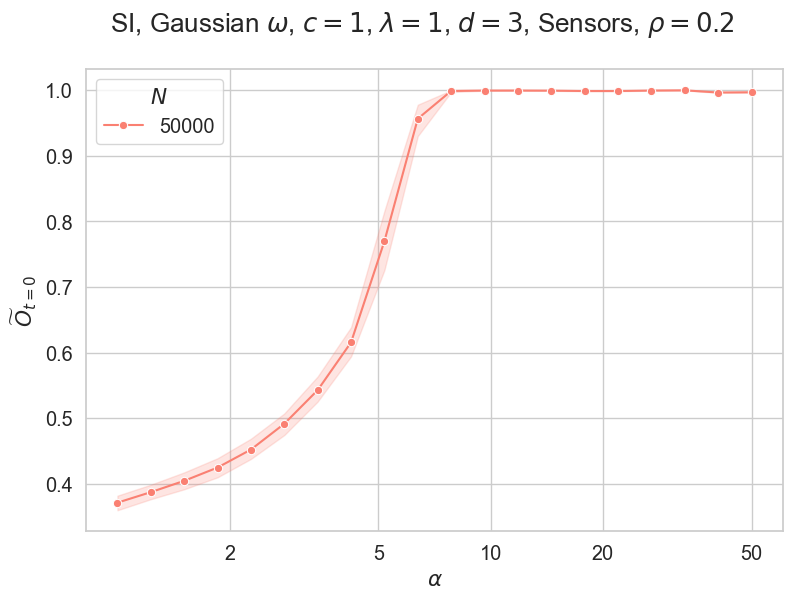

In [47]:
df_sens = data_frame[data_frame["c"]==1].copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $\lambda=1$, $d=3$, Sensors, $\rho = 0.2$ ")
sns.lineplot(data=df_sens, x=r"$\alpha$", y=r"$\widetilde{O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r")
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])

#### Together

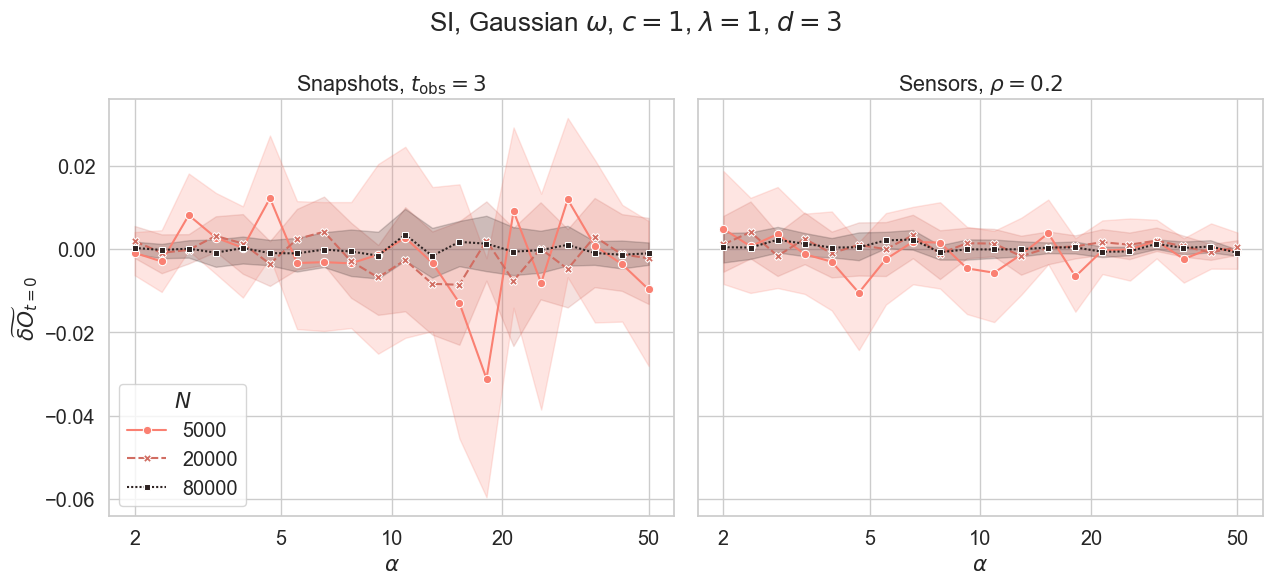

In [219]:
#Put the last two plosts side by side in a single figure

fig, axs = plt.subplots(1, 2, figsize=(13,6), sharey=True)
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $\lambda=1$, $d=3$ ")
sns.lineplot(data=df_snap, x=r"$\alpha$", y=r"$\widetilde{\delta O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[0])
ax = axs[0]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"Snapshots, $t_{\rm obs} = 3$")
sns.lineplot(data=df_sens, x=r"$\alpha$", y=r"$\widetilde{\delta O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[1], legend=False) 
ax = axs[1]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"Sensors, $\rho = 0.2$")
plt.tight_layout()

fig.savefig(f"./figures/Plot_Nishi_sens_snap.pdf")


#### snap, dSIR

In [39]:
file_name = "DF_20250502-132918_651.xz"
with lzma.open("./CLUSTER/DataCxtEpi/" + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [40]:
data_frame.iloc[:5,37:52]

$MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  $\widetilde{O}_{t=0}$  \
0    0.852938        0.842000          0.000325               0.069810   
1    0.853090        0.842083         -0.000527               0.072793   
2    0.850862        0.840231         -0.003249               0.054815   
3    0.853634        0.842312          0.002379               0.078701   
4    0.862642        0.846444         -0.000992               0.104820   

   $\widetilde{MO}_{t=0}$  $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  \
0                0.069227                      0.000583   0.988125   
1                0.069699                      0.003094   0.988800   
2                0.066538                     -0.011723   0.988875   
3                0.071799                      0.006902   0.989350   
4                0.105485                     -0.000665   0.989050   

   $O_{t=T,RND}$  $MO_{t=T}$  $MO_{t=T,RND}$  $\delta O_{t=T}$  \
0       0.988075    0.988513        0.988510         -0.000388   
1       0.988775    0.988555        0.988552          0.000245   
2       0.988950    0.988827        0.988816          0.000048   
3       0.989337    0.988482        0.988476          0.000868   
4       0.989150    0.987813        0.987788          0.001237   

   $\widetilde{O}_{t=T}$  $\widetilde{MO}_{t=T}$  \
0               0.004193                0.000271   
1               0.002227                0.000233   
2              -0.006787                0.000940   
3               0.001172                0.000533   
4              -0.009217                0.001994   

   $\widetilde{\delta O}_{t=T}$        SE  
0                      0.003922  1.472125  
1                      0.001994  1.615532  
2                     -0.007727  1.427770  
3                      0.000639  1.251399  
4                     -0.011211  1.406885

In [41]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [42]:
data_frame[data_frame[r"$N$"]==5000]

init graph_type   $N$  $d$  $\lambda$ s_type    S o_type    M  \
8     rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
9     rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
10    rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
11    rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
24    rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
...   ...        ...   ...  ...        ...    ...  ...    ...  ...   
1183  rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
1188  rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
1189  rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
1190  rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   
1191  rnd        rrg  5000    3        0.8  delta  0.5    rho  1.0   

      iter_space  ...  $R_{SE}$  $R_{MSE}$  $\delta R_{SE}$  \
8            100  ...  0.593725   0.592029         0.001696   
9            100  ...  0.611339   0.610119         0.001220   
10           100  ...  0.591158   0.593458        -0.002300   
11           100  ...  0.584127   0.580290         0.003837   
24           100  ...  0.624592   0.628019        -0.003427   
...          ...  ...       ...        ...              ...   
1183         100  ...  0.668138   0.651300         0.016838   
1188         100  ...  0.806245   0.809871        -0.003626   
1189         100  ...  0.814604   0.807641         0.006963   
1190         100  ...  0.751640   0.732694         0.018946   
1191         100  ...  0.802932   0.801481         0.001451   

                                             ConvChecks  free_entropy_BP  \
8     [[10, 0.001091292024459456, 9.680267927132778e...         0.296254   
9     [[9, 0.00037946855451639894, 7.498766397282079...         0.284870   
10    [[9, 0.0005418307849780479, 9.003211055422046e...         0.353279   
11    [[9, 0.00040002208353892565, 9.518114584967876...         0.332547   
24    [[10, 0.00032079039258936515, 9.04134021870650...         0.306028   
...                                                 ...              ...   
1183  [[10, 0.0005275860676717259, 7.86392767017652e...         0.379042   
1188  [[10, 0.012857340014269802, 6.917426025500908e...         0.220803   
1189  [[10, 0.012554534488879887, 6.211802495559497e...         0.238803   
1190  [[10, 0.017143655193710416, 5.9842030792428e-0...         0.183971   
1191  [[10, 0.0070681050248942445, 6.83311105346869e...         0.325786   

      free_entropy_AMP total_free_entropy  $\rho$  $\delta$   $\alpha$  
8            -0.698387          -0.402133     1.0       0.5   2.807412  
9            -0.695711          -0.410841     1.0       0.5   2.807412  
10           -0.692871          -0.339591     1.0       0.5   2.807412  
11           -0.692873          -0.360326     1.0       0.5   2.807412  
24           -0.695844          -0.389816     1.0       0.5   3.326680  
...                ...                ...     ...       ...        ...  
1183         -0.707703          -0.328661     1.0       0.5  15.290520  
1188         -1.687492          -1.466689     1.0       0.5  50.000000  
1189         -1.184179          -0.945376     1.0       0.5  50.000000  
1190         -1.695095          -1.511124     1.0       0.5  50.000000  
1191         -0.960253          -0.634467     1.0       0.5  50.000000  

[400 rows x 66 columns]

In [43]:
sns.set_theme(style="whitegrid",font_scale=1.3)

[Text(2, 0, '2'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(50, 0, '50')]

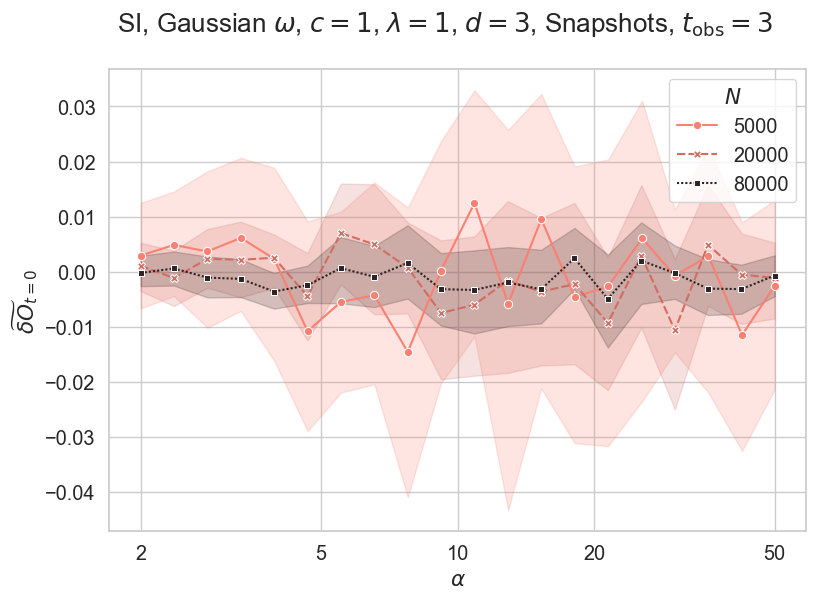

In [45]:
df_snap_2 = data_frame[data_frame["c"]==1].copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $\lambda=1$, $d=3$, Snapshots, $t_{\rm  obs} = 3$ ")
sns.lineplot(data=df_snap_2, x=r"$\alpha$", y=r"$\widetilde{\delta O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r")
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])

#### sens, dSIR

In [46]:
file_name = "DF_20250502-132815_703.xz"
with lzma.open("./CLUSTER/DataCxtEpi/" + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [47]:
data_frame.iloc[:5,37:52]

$MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  $\widetilde{O}_{t=0}$  \
0    0.929327        0.842990         -0.000502               0.544844   
1    0.928928        0.841477         -0.001678               0.541009   
2    0.929090        0.841709         -0.002240               0.537245   
3    0.930878        0.843026         -0.000603               0.560407   
4    0.970101        0.830912         -0.002501               0.807143   

   $\widetilde{MO}_{t=0}$  $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  \
0                0.549882                     -0.005038   0.991325   
1                0.551663                     -0.010653   0.990850   
2                0.552029                     -0.014784   0.990700   
3                0.559660                      0.000746   0.991613   
4                0.823174                     -0.016031   0.988200   

   $O_{t=T,RND}$  $MO_{t=T}$  $MO_{t=T,RND}$  $\delta O_{t=T}$  \
0       0.988975    0.990949        0.988618          0.000376   
1       0.988675    0.990916        0.988722         -0.000066   
2       0.988450    0.990856        0.988536         -0.000156   
3       0.989175    0.990849        0.988402          0.000764   
4       0.986600    0.991571        0.989971         -0.003371   

   $\widetilde{O}_{t=T}$  $\widetilde{MO}_{t=T}$  \
0               0.213152                0.204783   
1               0.192053                0.194534   
2               0.194805                0.202374   
3               0.225173                0.210992   
4               0.119403                0.159540   

   $\widetilde{\delta O}_{t=T}$        SE  
0                      0.008369  2.235211  
1                     -0.002481  1.687371  
2                     -0.007569  2.097682  
3                      0.014181  1.782423  
4                     -0.040137  2.266783

In [48]:
data_frame[r"$\delta O_{t=0}$"]

0      -0.000502
1      -0.001678
2      -0.002240
3      -0.000603
4      -0.002501
          ...   
1111    0.000427
1112    0.000387
1113   -0.000026
1114    0.000247
1115    0.000194
Name: $\delta O_{t=0}$, Length: 1116, dtype: float64

In [49]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [50]:
sns.set_theme(style="whitegrid",font_scale=1.3)

[Text(2, 0, '2'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(50, 0, '50')]

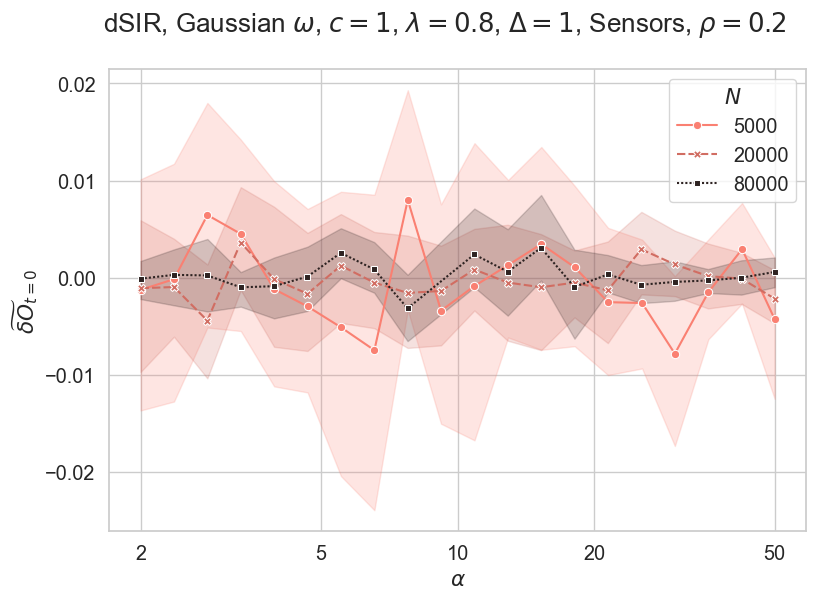

In [52]:
df_sens_2 = data_frame[data_frame["c"]==1].copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"dSIR, Gaussian $\omega$, $c=1$, $\lambda=0.8$, $\Delta=1$, Sensors, $\rho = 0.2$ ")
sns.lineplot(data=df_sens_2, x=r"$\alpha$", y=r"$\widetilde{\delta O}_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r")
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])

#### All together

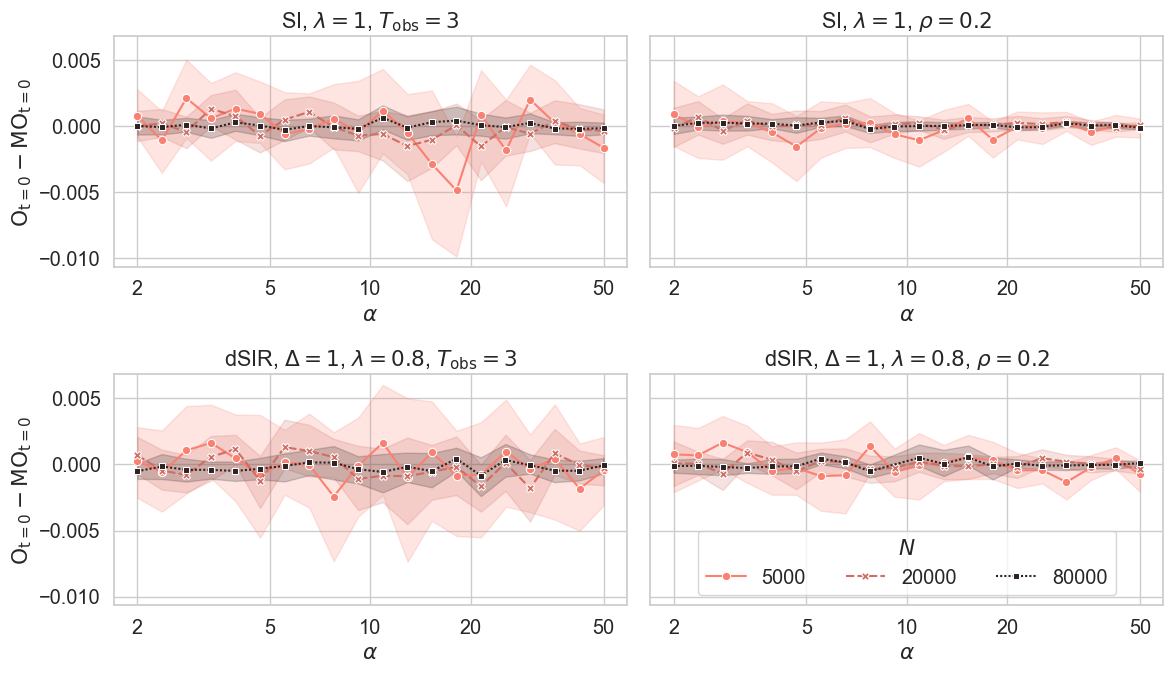

In [65]:
# Put the last four plots on a 2x2 figure

fig, axs = plt.subplots(2, 2, figsize=(12,7), sharey=True)
#fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $\lambda=1$, $d=3$ ")
sns.lineplot(data=df_snap, x=r"$\alpha$", y=r"$\delta O_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[0,0], legend=False)
ax = axs[0,0]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"SI, $\lambda=1$, $T_{\rm obs} = 3$")
ax.set_ylabel(r"$\rm{O}_{t=0} - \rm{MO}_{t=0}$")
sns.lineplot(data=df_sens, x=r"$\alpha$", y=r"$\delta O_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[0,1], legend=False)
ax = axs[0,1]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"SI, $\lambda=1$, $\rho = 0.2$")

sns.lineplot(data=df_snap_2, x=r"$\alpha$", y=r"$\delta O_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[1,0], legend=False)
ax = axs[1,0]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"dSIR, $\Delta=1$, $\lambda=0.8$, $T_{\rm obs} = 3$")
ax.set_ylabel(r"$\rm{O}_{t=0} - \rm{MO}_{t=0}$")

s1 = sns.lineplot(data=df_sens_2, x=r"$\alpha$", y=r"$\delta O_{t=0}$", hue=r"$N$", markers=True, errorbar=("ci", 99), style=r"$N$", palette="dark:salmon_r", ax=axs[1,1])
ax = axs[1,1]
ax.set_xscale("log")
ax.set_xticks([2,5,10,20,50])
ax.set_xticklabels([2,5,10,20,50])
ax.set_title(r"dSIR, $\Delta=1$, $\lambda=0.8$, $\rho = 0.2$")
s1.legend(loc='lower center', ncol=3, title=r"$N$")#, fontsize=12)

plt.tight_layout()
fig.savefig(f"./figures/Plot_Nishi_sens_snap_SI_dSIR.pdf")

### Lambda

#### $\rho$

In [33]:
load_Dir = "./CLUSTER/DataCxtEpi/data_new/"

In [34]:
file_name = "DF_20250620-lam_rho_3.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [35]:
data_frame["c"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2893    1.0
2894    1.0
2895    1.0
2896    1.0
2897    1.0
Name: c, Length: 2898, dtype: float64

In [36]:
data_frame[r"$M$"]

0       20000
1       20000
2       20000
3       20000
4       20000
        ...  
2893    20000
2894    20000
2895    20000
2896    20000
2897    20000
Name: $M$, Length: 2898, dtype: int64

In [37]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [38]:
import numpy as np

#sorted_alpha = sorted(data_frame[r"$\alpha$"].unique())
#np.savetxt("sorted_alpha.txt", sorted_alpha, fmt='%f')

In [39]:
sns.set_theme(style="whitegrid",font_scale=1.3)

In [40]:
data_frame_rho = data_frame[(data_frame[r"$\lambda$"]==0.1) | (data_frame[r"$\lambda$"]==0.2) |  (data_frame[r"$\lambda$"]==0.4) |  (data_frame[r"$\lambda$"]==0.8) |  (data_frame[r"$\lambda$"]==1) ] 

In [41]:
#import MO_tab from MO.csv
MO_tab = pd.read_csv("./CLUSTER/DataCxtEpi/data_new/MO.csv")
rho_tab = sorted(data_frame_rho[r"$\rho$"].unique())

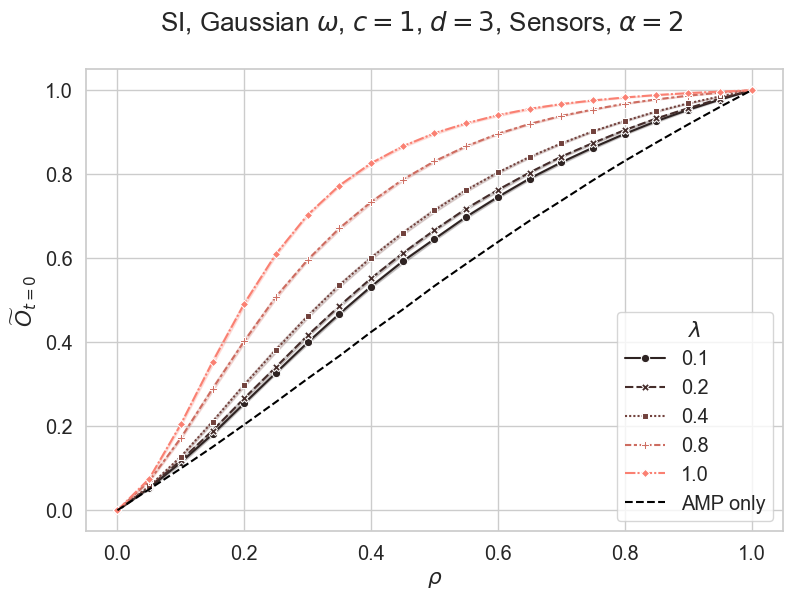

In [ ]:
#df_sens = data_frame.copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $d=3$, Sensors, $\alpha=2$ ")
sns.lineplot(data=data_frame_rho, x=r"$\rho$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon", legend="full")
ax.plot(rho_tab, MO_tab, color="black", linestyle="--", label="AMP only")
#ax.set_xscale("log")
#ax.set_xticks([1,5,10,20,50])
#ax.set_xticklabels([1,5,10,20,50])
#ax.set_yscale("log")
# put the AMP only line in the legend along with seaborn lines
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='AMP only', color='black', linestyle='--')
ax.legend(handles=handles, labels=labels, title=r"$\lambda$", loc='lower right')
#fig.savefig(f"./figures/Plot_lambda_AMP.pdf")

#### $\lambda$

In [44]:
load_Dir = "./data_shared/"

In [45]:
file_name = "DF_lambda_final.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [133]:
data_frame[r"$\alpha$"] = np.int32(data_frame[r"$N$"]/data_frame[r"$M$"])

In [142]:
data_frame["c"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3835    1.0
3836    1.0
3837    1.0
3838    1.0
3839    1.0
Name: c, Length: 3840, dtype: float64

In [134]:
import numpy as np

#sorted_alpha = sorted(data_frame[r"$\alpha$"].unique())
#np.savetxt("sorted_alpha.txt", sorted_alpha, fmt='%f')

In [135]:
sns.set_theme(style="whitegrid",font_scale=1.3)

In [136]:
data_frame_lam = data_frame[(data_frame[r"$\alpha$"]==1) | (data_frame[r"$\alpha$"]==2) |  (data_frame[r"$\alpha$"]==5) |  (data_frame[r"$\alpha$"]==10) |  (data_frame[r"$\alpha$"]==20) | (data_frame[r"$\alpha$"]==40) ]

<Axes: xlabel='$\\lambda$', ylabel='$\\widetilde{O}_{t=0}$'>

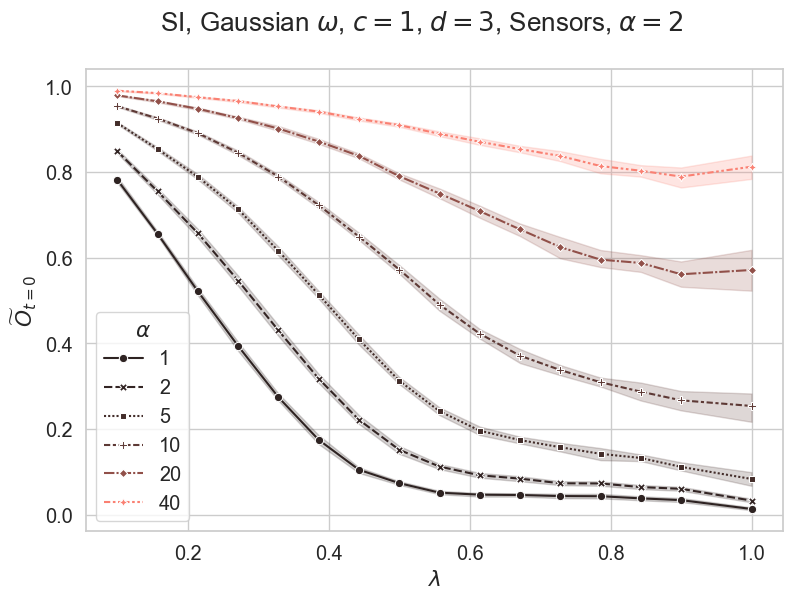

In [ ]:
#df_sens = data_frame.copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
sns.lineplot(data=data_frame_lam, x=r"$\lambda$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\alpha$", markers=True, errorbar=("ci", 99), style=r"$\alpha$", palette="dark:salmon", legend="full")
#ax.set_xscale("log")
#ax.set_xticks([1,5,10,20,50])
#ax.set_xticklabels([1,5,10,20,50])
#ax.set_yscale("log")
# put the AMP only line in the legend along with seaborn lines
#ax.legend(handles=handles, labels=labels, title=r"$\lambda$", loc='lower right')
#fig.savefig(f"./figures/Plot_lambda_AMP.pdf")

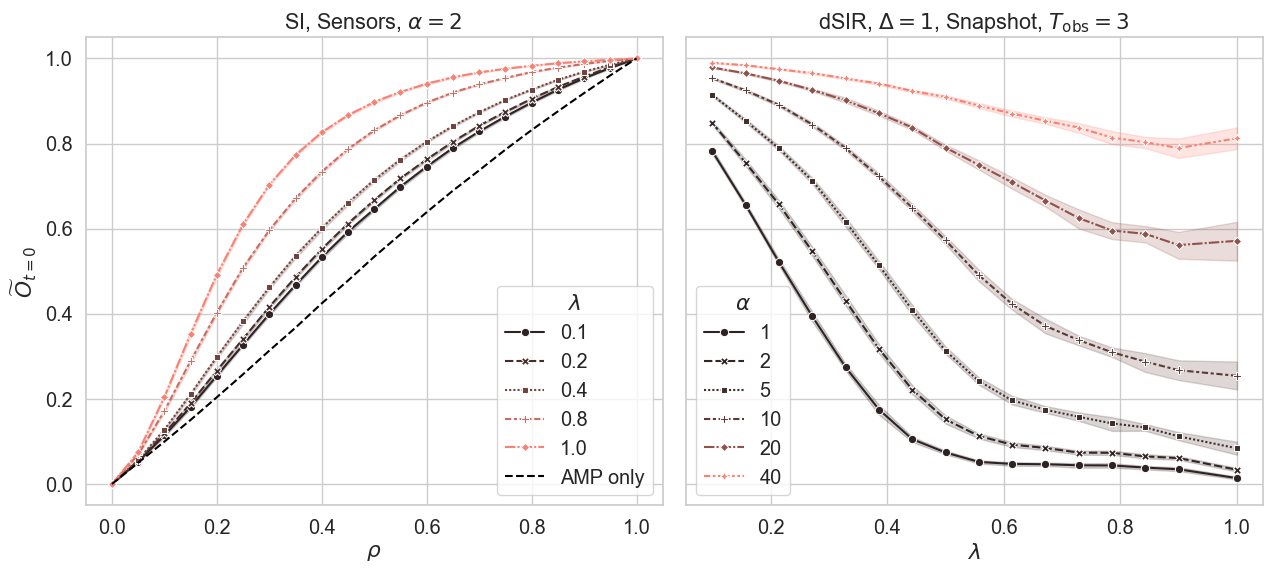

In [146]:
#df_sens = data_frame.copy()

fig,axs = plt.subplots(1, 2, figsize=(13,6), sharey=True)
#fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $d=3$, Sensors, $\alpha=2$ ")
ax = axs[0]
ax.title.set_text(r"SI, Sensors, $\alpha=2$ ")
sns.lineplot(data=data_frame_rho, x=r"$\rho$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon", legend="full", ax=ax)
ax.plot(rho_tab, MO_tab, color="black", linestyle="--", label="AMP only")
#ax.set_xscale("log")
#ax.set_xticks([1,5,10,20,50])
#ax.set_xticklabels([1,5,10,20,50])
#ax.set_yscale("log")
# put the AMP only line in the legend along with seaborn lines
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='AMP only', color='black', linestyle='--')
ax.legend(handles=handles, labels=labels, title=r"$\lambda$", loc='lower right')
ax = axs[1]
ax.title.set_text(r"dSIR, $\Delta=1$, Snapshot, $T_{\rm obs}=3$ ")
sns.lineplot(data=data_frame_lam, x=r"$\lambda$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\alpha$", markers=True, errorbar=("ci", 99), style=r"$\alpha$", palette="dark:salmon", legend="full")

#ax.set_xscale("log")
#ax.set_xticks([1,5,10,20,50])
#ax.set_xticklabels([1,5,10,20,50])
#ax.set_yscale("log")
# put the AMP only line in the legend along with seaborn lines

fig.tight_layout()
fig.savefig(f"./figures/Plot_lambda_alpha.pdf")

#### $\alpha$

In [174]:
load_Dir = "./CLUSTER/DataCxtEpi/data_new/"

In [175]:
file_name = "DF_20250616-lam_M.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\delta$"] = data_frame["S"]

In [176]:
data_frame.iloc[:5,50:60]

$\widetilde{\delta O}_{t=T}$        SE       MSE  $SE_{RND}$  $MSE_{RND}$  \
0                      0.001948  1.179007  1.176430    3.009608     3.004007   
1                      0.000000  0.109331  0.111692    0.999790     0.999441   
2                      0.023330  0.516133  0.523649    1.415353     1.411019   
3                     -0.000266  4.375734  4.183901   11.562279    10.990744   
4                      0.000000  0.690744  0.705431    1.394080     1.400140   

   $\delta SE$  $R_{SE}$  $R_{MSE}$  $\delta R_{SE}$  \
0     0.002577  0.608252   0.608380        -0.000127   
1    -0.002361  0.890646   0.888245         0.002400   
2    -0.007516  0.635333   0.628886         0.006447   
3     0.191832  0.621551   0.619325         0.002226   
4    -0.014687  0.504516   0.496171         0.008345   

                                          ConvChecks  
0  [[10, 0.001786766417579383, 7.315871849075235e...  
1  [[10, 0.010265568311182305, 7.921661445079166e...  
2  [[10, 0.00127823543619493, 8.135666459389682e-...  
3  [[10, 0.00394354702468952, 9.104877823757506e-...  
4  [[7, 0.00042518354651882584, 9.6651421856479e-...

In [177]:
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [ ]:
import numpy as np

#sorted_alpha = sorted(data_frame[r"$\alpha$"].unique())
#np.savetxt("sorted_alpha.txt", sorted_alpha, fmt='%f')

In [34]:
sns.set_theme(style="whitegrid",font_scale=1.3)

[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(25, 0, '25'),
 Text(50, 0, '50')]

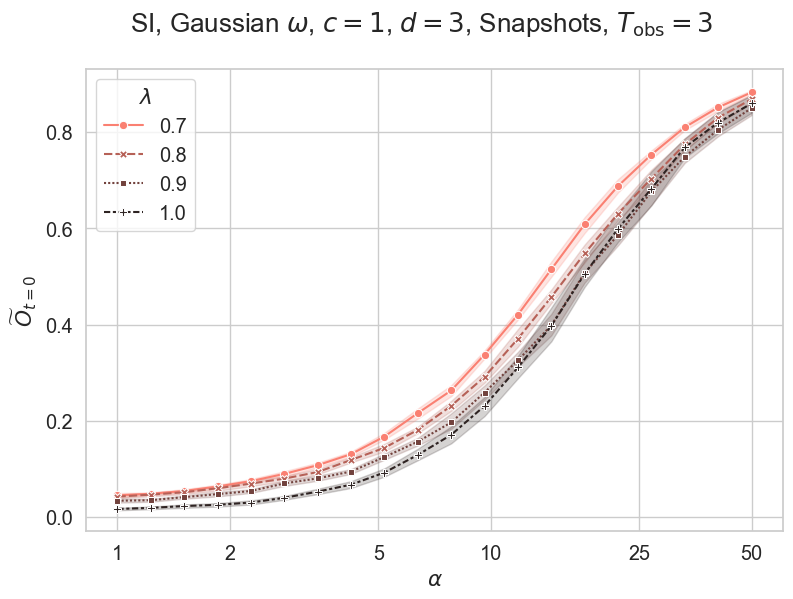

In [23]:
#df_sens = data_frame.copy()

fig,ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"SI, Gaussian $\omega$, $c=1$, $d=3$, Snapshots, $T_{\rm obs} = 3$ ")
sns.lineplot(data=data_frame, x=r"$\alpha$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon_r")
ax.set_xscale("log")
ax.set_xticks([1,2,5,10,25,50])
ax.set_xticklabels([1,2,5,10,25,50])
#ax.set_yscale("log")

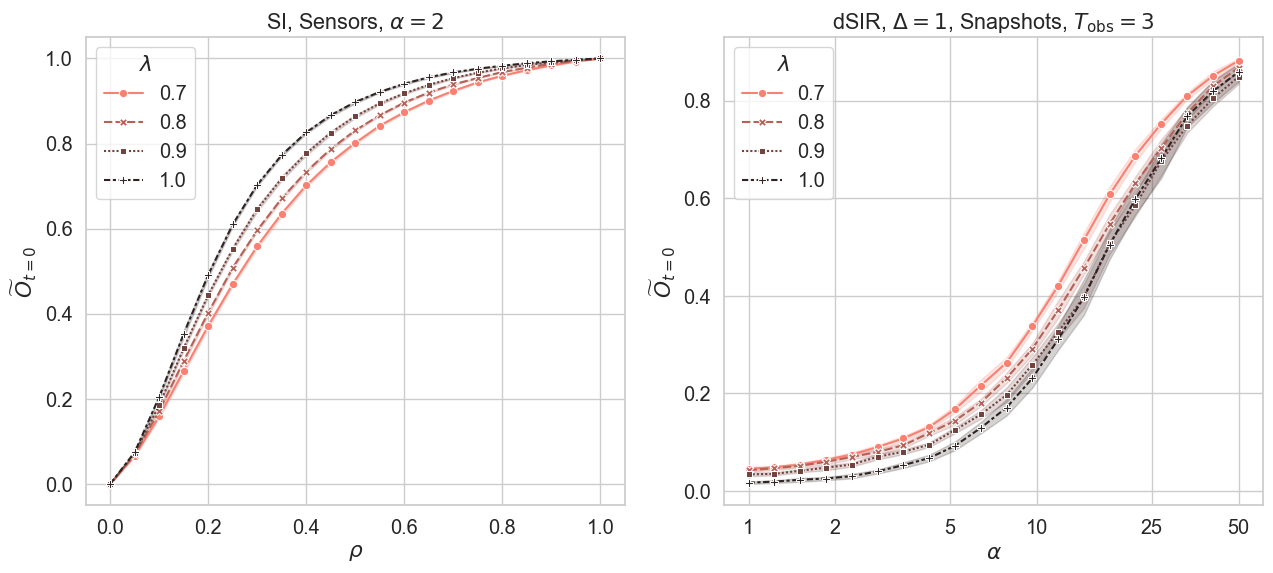

In [40]:
# 2x 1 figure with the two previous plots
fig, axs = plt.subplots(1, 2, figsize=(13,6))
sns.lineplot(data=data_frame_rho, x=r"$\rho$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon_r", ax=axs[0])
axs[0].set_title(r"SI, Sensors, $\alpha = 2$")
sns.lineplot(data=data_frame, x=r"$\alpha$", y=r"$\widetilde{O}_{t=0}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon_r", ax=axs[1])
axs[1].set_title(r"dSIR, $\Delta = 1$, Snapshots, $T_{\rm obs} = 3$")
plt.tight_layout()
axs[1].set_xscale("log")
axs[1].set_xticks([1,2,5,10,25,50])
axs[1].set_xticklabels([1,2,5,10,25,50])
fig.savefig(f"./figures/Plot_lambda.pdf")

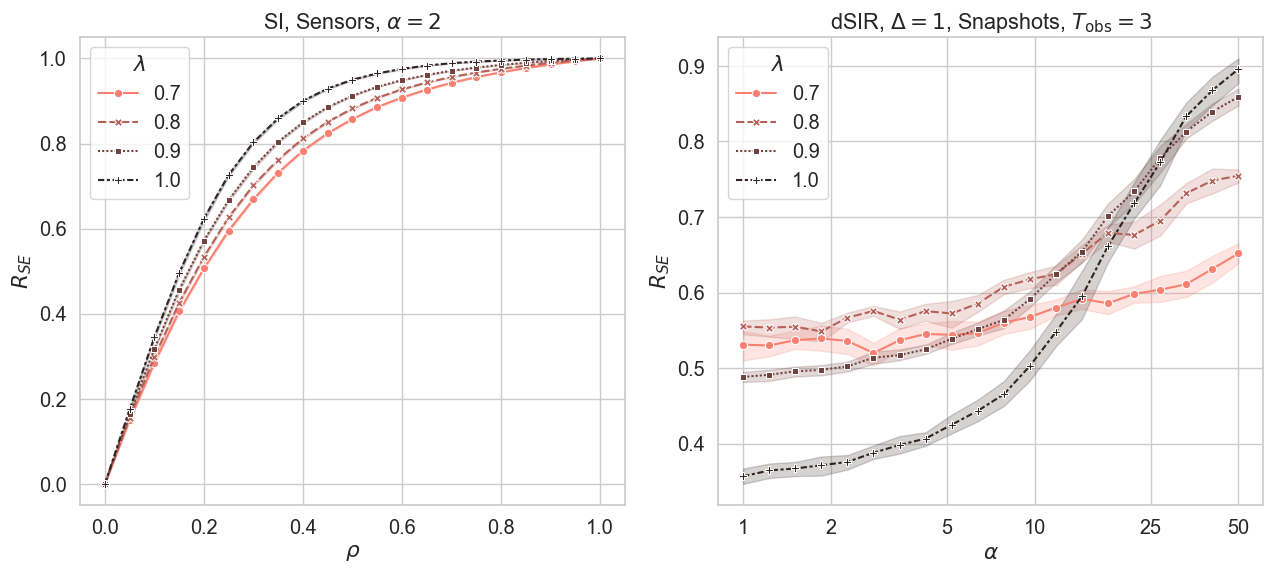

In [45]:
# 2x 1 figure with the two previous plots
fig, axs = plt.subplots(1, 2, figsize=(13,6))
sns.lineplot(data=data_frame_rho, x=r"$\rho$", y=r"$R_{SE}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon_r", ax=axs[0])
axs[0].set_title(r"SI, Sensors, $\alpha = 2$")
sns.lineplot(data=data_frame, x=r"$\alpha$", y=r"$R_{SE}$", hue=r"$\lambda$", markers=True, errorbar=("ci", 99), style=r"$\lambda$", palette="dark:salmon_r", ax=axs[1])
axs[1].set_title(r"dSIR, $\Delta = 1$, Snapshots, $T_{\rm obs} = 3$")
plt.tight_layout()
axs[1].set_xscale("log")
axs[1].set_xticks([1,2,5,10,25,50])
axs[1].set_xticklabels([1,2,5,10,25,50])
fig.savefig(f"./figures/Plot_lambda_SE.pdf")

## Rademacher $u$

### Old data

In [4]:
load_Dir = "./data_shared/"

In [5]:
file_name = "DF_20250525-211918_962.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
len(data_frame)

6300

In [6]:
data_frame.keys()

Index(['init', 'graph_type', '$N$', '$d$', '$\lambda$', 's_type', 'S',
       'o_type', 'M', 'iter_space', 'seed', 'tol', 'n_iter', 'obs_type',
       'snap_time', 'T_max', 'mask_type', '$\mu$', 'tol2', 'it_max', '$T$',
       '$f_S$', '$f_I$', '$T_O$', '$T_{BP}$', '$infer_up_to$', '$\Delta$',
       'damping', 'c', '$M$', 'uRad', 'error', 'iteration', 'it_final', 'logL',
       '$O_{t=0}$', '$O_{t=0,RND}$', '$MO_{t=0}$', '$MO_{t=0,RND}$',
       '$\delta O_{t=0}$', '$\widetilde{O}_{t=0}$', '$\widetilde{MO}_{t=0}$',
       '$\widetilde{\delta O}_{t=0}$', '$O_{t=T}$', '$O_{t=T,RND}$',
       '$MO_{t=T}$', '$MO_{t=T,RND}$', '$\delta O_{t=T}$',
       '$\widetilde{O}_{t=T}$', '$\widetilde{MO}_{t=T}$',
       '$\widetilde{\delta O}_{t=T}$', 'SE', 'MSE', '$SE_{RND}$',
       '$MSE_{RND}$', '$\delta SE$', '$R_{SE}$', '$R_{MSE}$',
       '$\delta R_{SE}$', 'ConvChecks', 'free_entropy_BP', 'free_entropy_AMP',
       'total_free_entropy'],
      dtype='object')

In [7]:
data_frame[data_frame["iteration"]>2499].iloc[:,0:5]

Empty DataFrame
Columns: [init, graph_type, $N$, $d$, $\lambda$]
Index: []

In [8]:
data_frame[data_frame["iteration"]>2499].sort_values(by="error")["error"][-20:]

Series([], Name: error, dtype: float64)

In [9]:
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [10]:
data_frame_tot = data_frame.copy()
data_frame = data_frame[data_frame["init"]=="rnd"]
data_frame.iloc[:,0:5]

init graph_type     $N$  $d$  $\lambda$
0     rnd        rrg  160000    3        1.0
1     rnd        rrg  160000    3        1.0
2     rnd        rrg  160000    3        1.0
3     rnd        rrg  160000    3        1.0
4     rnd        rrg  160000    3        1.0
...   ...        ...     ...  ...        ...
6295  rnd        rrg   80000    3        1.0
6296  rnd        rrg   80000    3        1.0
6297  rnd        rrg   80000    3        1.0
6298  rnd        rrg   80000    3        1.0
6299  rnd        rrg   80000    3        1.0

[6300 rows x 5 columns]

In [11]:
datacm1 = data_frame[(data_frame["c"] == -1) & (data_frame[r"$\alpha$"] < 50)]
datac0 = data_frame[(data_frame["c"] == 0) & (data_frame[r"$\alpha$"] < 50)]
datac1 = data_frame[(data_frame["c"] == 1) & (data_frame[r"$\alpha$"] < 50)]

In [12]:
datacm1_ = data_frame[ (data_frame["c"] == -1) & (data_frame[r"$\alpha$"] < 50) & ((data_frame[r"$\widetilde{MO}_{t=0}$"] - data_frame[r"$\widetilde{O}_{t=0}$"]) <0.005) ]
datac1_ = data_frame[ (data_frame["c"] == 1) & (data_frame[r"$\alpha$"] < 50) & ((data_frame[r"$\widetilde{MO}_{t=0}$"] - data_frame[r"$\widetilde{O}_{t=0}$"]) <0.005) ]
datac0_ = data_frame[ (data_frame["c"] == 0) & (data_frame[r"$\alpha$"] < 50) & ((data_frame[r"$\widetilde{MO}_{t=0}$"] - data_frame[r"$\widetilde{O}_{t=0}$"]) <0.005) ]
len(datac0_)

1974

<Axes: xlabel='$\\rho$', ylabel='$R_{MSE}$'>

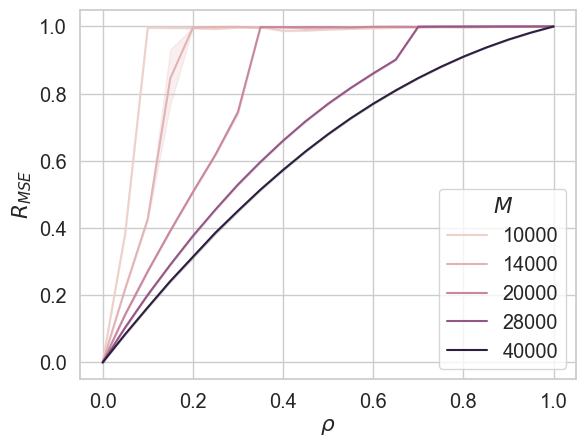

In [13]:
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datac0_,x=r"$\rho$",y=r'$R_{MSE}$', hue=r"$M$")

In [14]:
#N=20000
#lam=1
palette = sns.color_palette("viridis",8)[1:6]

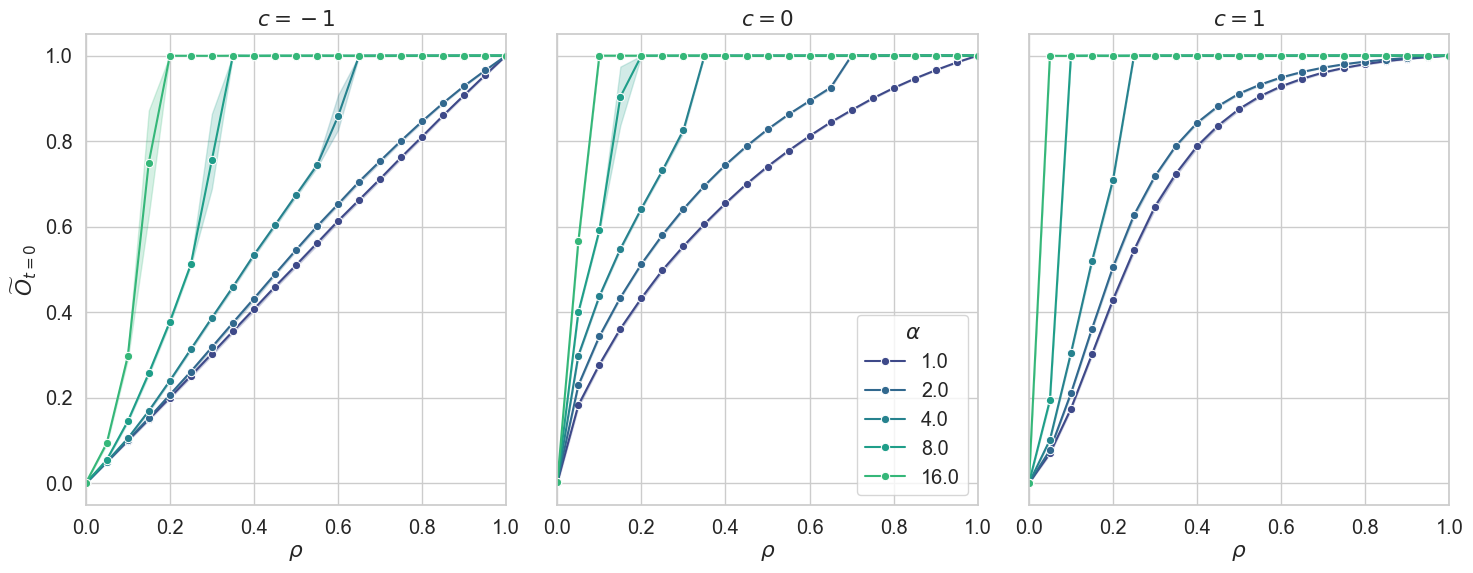

In [15]:
#Put all three previous plots side by side in a single figure
x_s= r"$\rho$"
y_s = "$\widetilde{MO}_{t=0}$"
y_s = r'$R_{SE}$'
y_s = "$\widetilde{O}_{t=0}$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.lineplot(data=datacm1_,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0_,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),errorbar=("ci",99),marker="o",legend=False)
#sns.scatterplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),marker="o",s=20,edgecolor="black",linewidth=0.5)
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/O_SI_Rademacher_omega_lam{lam}.png",dpi=600)

##### Prove c=1


/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_55803/1651195650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datac1_["1-$\widetilde{O}_{t=0}$"] = 1 - datac1_[r"$\widetilde{O}_{t=0}$"]
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_55803/1651195650.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=datac1_[datac1_[r"$\alpha$"] == 2],y=y_s, x=x_s,palette=sns.color_palette(palette, len(palette)),errorbar=("ci",99),marker="o",legend=False)


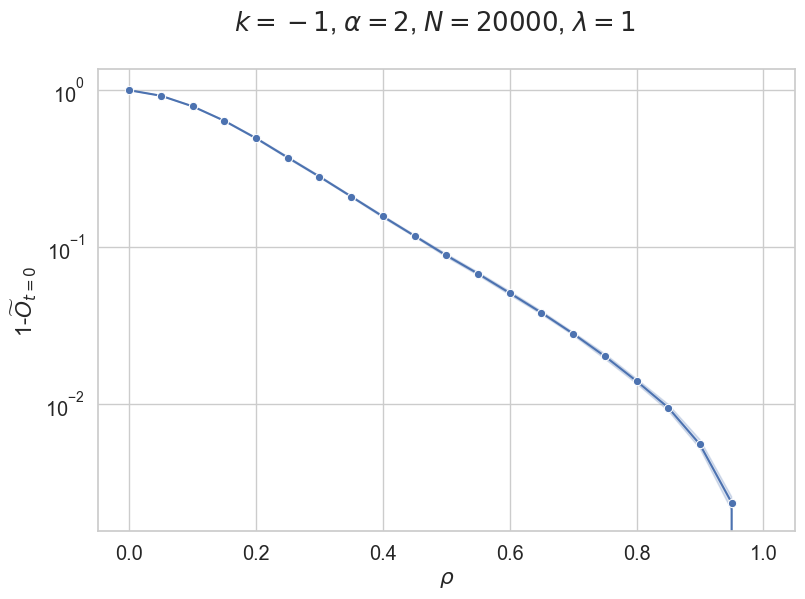

In [20]:
y_s = "1-$\widetilde{O}_{t=0}$"
datac1_["1-$\widetilde{O}_{t=0}$"] = 1 - datac1_[r"$\widetilde{O}_{t=0}$"]
x_s= r"$\rho$"
fig, axs = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle(r"$k=-1$, $\alpha=2$, $N=20000$, $\lambda=1$")
sns.lineplot(data=datac1_[datac1_[r"$\alpha$"] == 2],y=y_s, x=x_s,palette=sns.color_palette(palette, len(palette)),errorbar=("ci",99),marker="o",legend=False)
axs.set_yscale("log")

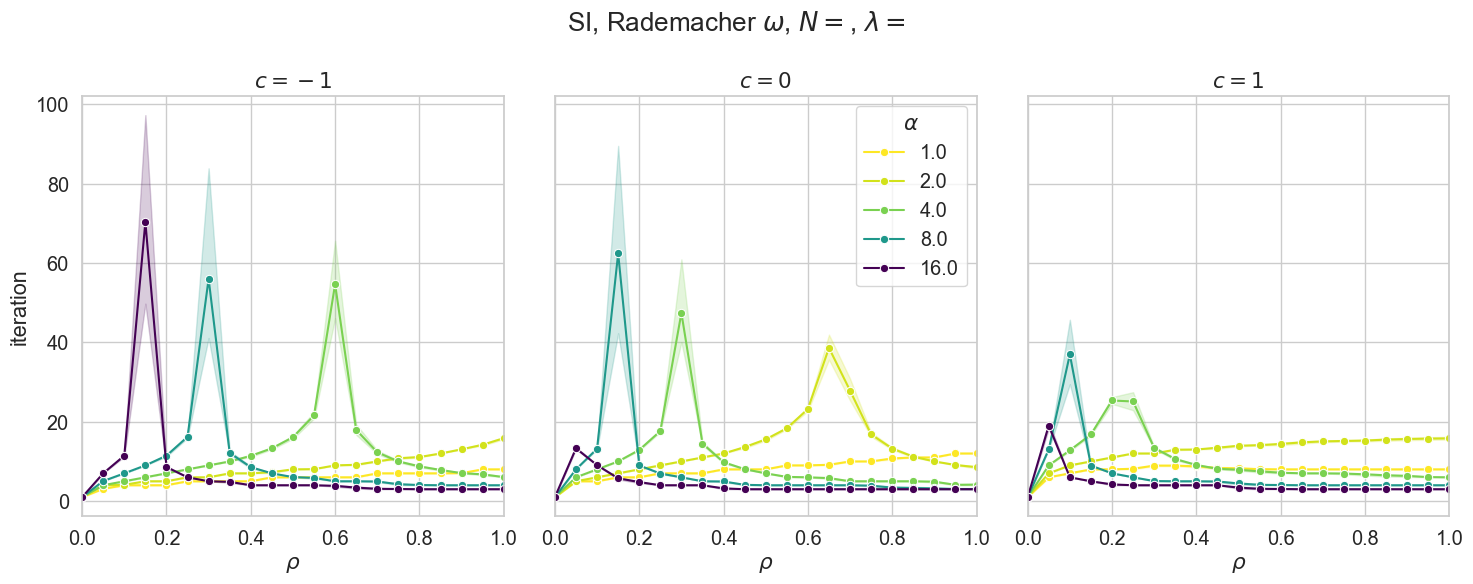

In [290]:
#Put all three previous plots side by side in a single figure
x_s= r"$\rho$"
y_s = "iteration"
#y_s = r'$R_{MSE}$'
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N=$, $\lambda=$")
sns.lineplot(data=datacm1,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/MSE_SI_Rademacher_omega_N{N}_lam{lam}.png",dpi=600)

In [291]:
#y_s = '$MO_{t=0}$'
#y_s = 'MSE'
y_s = r'$R_{SE}$'
y_s = r"$\widetilde{O}_{t=0}$"

In [292]:
rho_list = np.sort(data_frame_BP[r"$\rho$"].unique())
rMO_m1 = np.zeros(len(rho_list))
rMO_0 = np.zeros(len(rho_list))
rMO_1 = np.zeros(len(rho_list))
for i,rho in enumerate(rho_list):
    rMO_m1[i] = dataBPcm1[dataBPcm1[r"$\rho$"] == rho][y_s].mean()
    rMO_0[i] = dataBPc0[dataBPc0[r"$\rho$"] == rho][y_s].mean()
    rMO_1[i] = dataBPc1[dataBPc1[r"$\rho$"] == rho][y_s].mean()

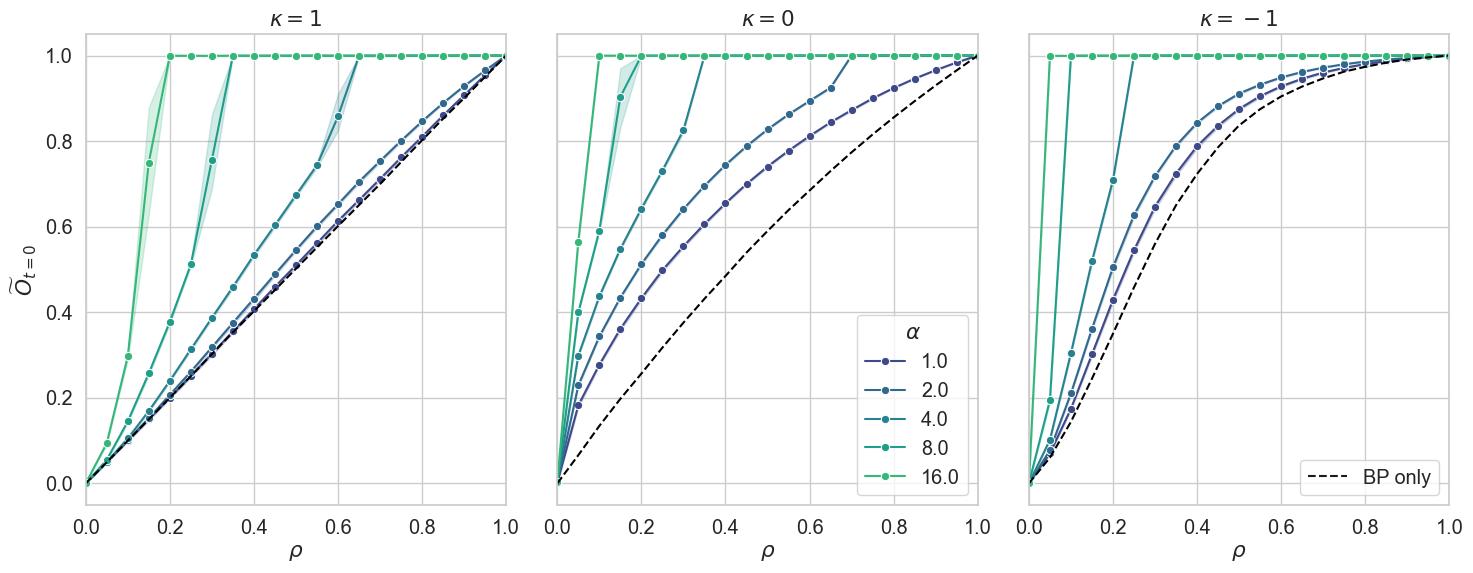

In [293]:
#Add BP curves to the previous plot
x_s= r"$\rho$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1_,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0_,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99))
axs[0].set_title(r"$\kappa=1$")
axs[1].set_title(r"$\kappa=0$")
axs[2].set_title(r"$\kappa=-1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
axs[0].plot(rho_list, rMO_m1, color="black", linestyle="--")
axs[1].plot(rho_list, rMO_0, color="black", linestyle="--")
axs[2].plot(rho_list, rMO_1, color="black", linestyle="--")
line = Line2D([0], [0], label='manual line', color='k', linestyle='--')
axs[2].legend([line], ['BP only'], loc='lower right')
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/O_SI_Rademacher_omega_lam{lam}_BP.pdf")#,dpi=600)

In [294]:
y_s = "$\widetilde{\delta O}_{t=0}$"
#y_s = '$\delta R_{SE}$'

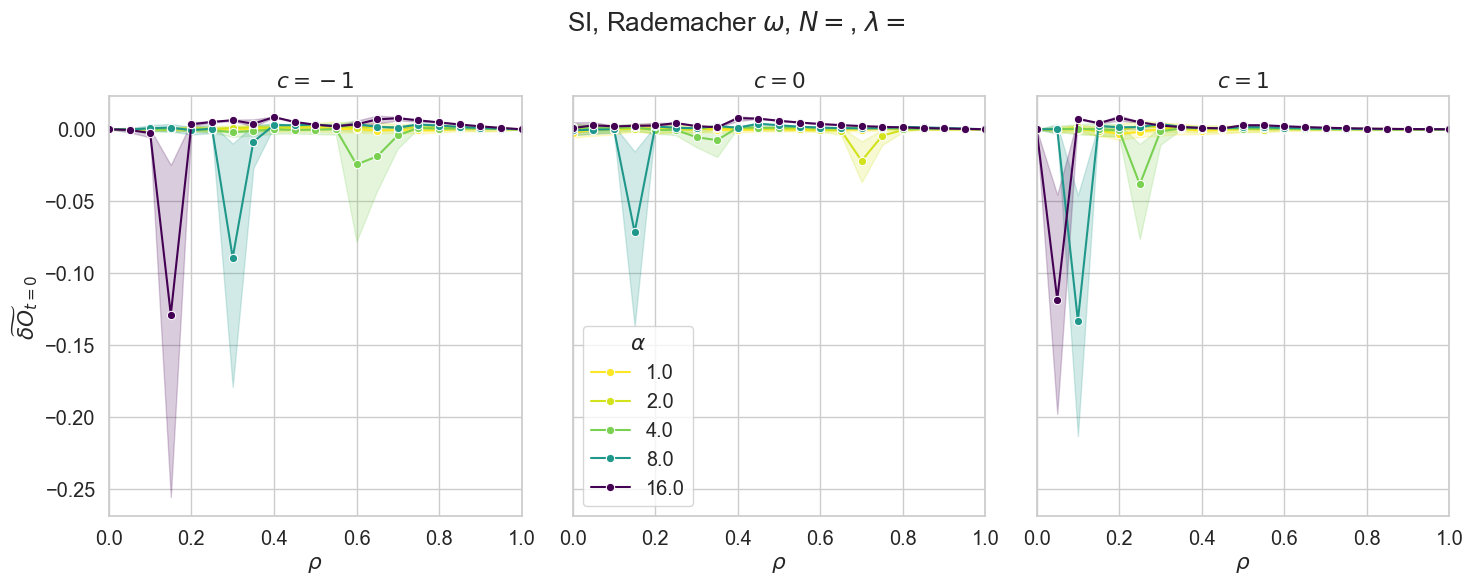

In [297]:
x_s= r"$\rho$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N=$, $\lambda=$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/Nishi_SE_SI_Rademacher_N{N}_lam{lam}.png",dpi=600)

In [298]:
datacm1tot = data_frame_tot[(data_frame_tot["c"] == -1) & (data_frame_tot[r"$\alpha$"] < 50)]
datac0tot = data_frame_tot[(data_frame_tot["c"] == 0) & (data_frame_tot[r"$\alpha$"] < 50)]
datac1tot = data_frame_tot[(data_frame_tot["c"] == 1) & (data_frame_tot[r"$\alpha$"] < 50)]

In [299]:
alpha = 10
y_s = "$\widetilde{O}_{t=0}$"
y_s = r'$R_{SE}$'

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_3452/2666412861.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=datacm1tot[datacm1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_3452/2666412861.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=datac0tot[datac0tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_3452/2666412861.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=datac1tot[datac1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))


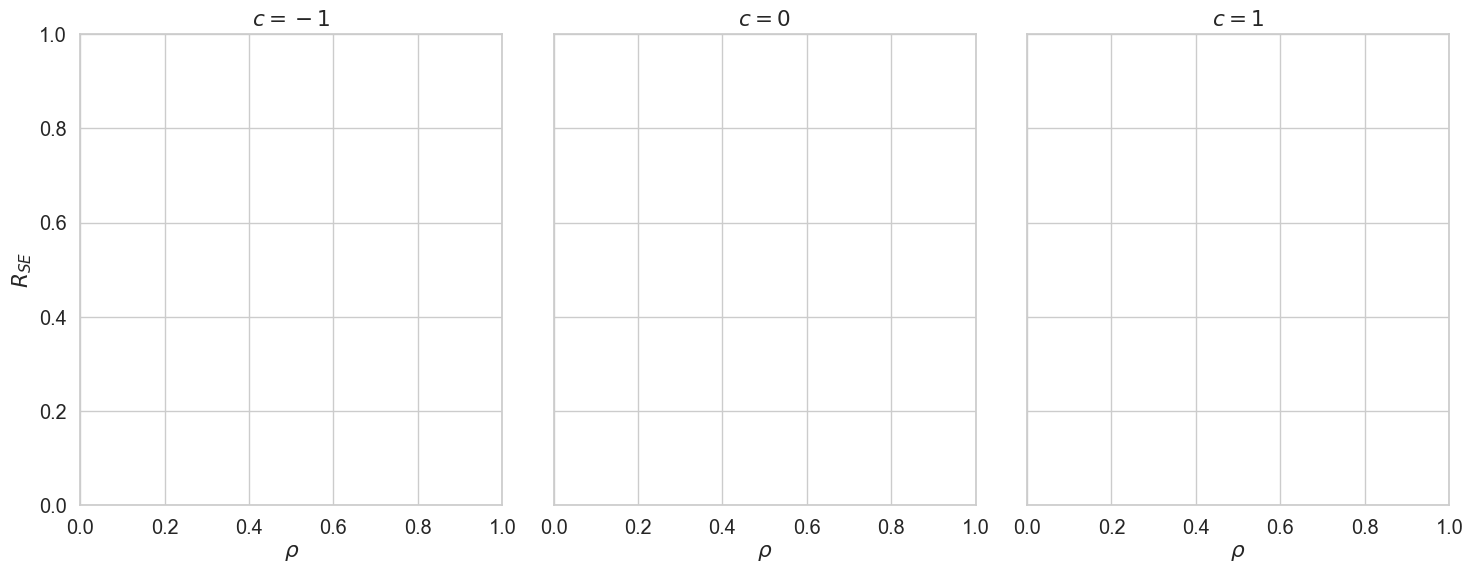

In [300]:
x_s= r"$\rho$"
hue_s = "init"

fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1tot[datacm1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0tot[datac0tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")   
sns.lineplot(data=datac1tot[datac1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

### New data

In [301]:
load_Dir = "./CLUSTER/DataCxtEpi/data_new/"

In [302]:
file_name = "DF_20250616-c2phd.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)
len(data_frame)

4099

In [303]:
data_frame.keys()

Index(['init', 'graph_type', '$N$', '$d$', '$\lambda$', 's_type', 'S',
       'o_type', 'M', 'iter_space', 'seed', 'tol', 'n_iter', 'obs_type',
       'snap_time', 'T_max', 'mask_type', '$\mu$', 'tol2', 'it_max', '$T$',
       '$f_S$', '$f_I$', '$T_O$', '$T_{BP}$', '$infer_up_to$', '$\Delta$',
       'damping', 'c', '$M$', 'uRad', 'error', 'iteration', 'it_final', 'logL',
       '$O_{t=0}$', '$O_{t=0,RND}$', '$MO_{t=0}$', '$MO_{t=0,RND}$',
       '$\delta O_{t=0}$', '$\widetilde{O}_{t=0}$', '$\widetilde{MO}_{t=0}$',
       '$\widetilde{\delta O}_{t=0}$', '$O_{t=T}$', '$O_{t=T,RND}$',
       '$MO_{t=T}$', '$MO_{t=T,RND}$', '$\delta O_{t=T}$',
       '$\widetilde{O}_{t=T}$', '$\widetilde{MO}_{t=T}$',
       '$\widetilde{\delta O}_{t=T}$', 'SE', 'MSE', '$SE_{RND}$',
       '$MSE_{RND}$', '$\delta SE$', '$R_{SE}$', '$R_{MSE}$',
       '$\delta R_{SE}$', 'ConvChecks', 'free_entropy_BP', 'free_entropy_AMP',
       'total_free_entropy'],
      dtype='object')

In [304]:
data_frame[data_frame["iteration"]>2499].iloc[:,0:5]

Empty DataFrame
Columns: [init, graph_type, $N$, $d$, $\lambda$]
Index: []

In [305]:
data_frame[data_frame["iteration"]>2499].sort_values(by="error")["error"][-20:]

Series([], Name: error, dtype: float64)

In [306]:
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [307]:
data_frame_tot = data_frame.copy()
data_frame = data_frame[data_frame["init"]=="rnd"]
data_frame.iloc[:,0:5]

init graph_type     $N$  $d$  $\lambda$
0     rnd        rrg   86602    3        1.0
1     rnd        rrg  122474    3        1.0
2     rnd        rrg   86602    3        1.0
3     rnd        rrg  122474    3        1.0
4     rnd        rrg   50000    3        1.0
...   ...        ...     ...  ...        ...
4094  rnd        rrg   86602    3        1.0
4095  rnd        rrg  244948    3        1.0
4096  rnd        rrg   50000    3        1.0
4097  rnd        rrg  173206    3        1.0
4098  rnd        rrg  122474    3        1.0

[4099 rows x 5 columns]

In [308]:
datacm2 = data_frame

In [309]:
len(datacm2)

4099

In [310]:
datacm2_ = data_frame[ (data_frame["c"] == 2) & ((data_frame[r"$\widetilde{MO}_{t=0}$"] - data_frame[r"$\widetilde{O}_{t=0}$"]) <0.005) ]
len(datacm2_)

3473

<Axes: xlabel='$\\rho$', ylabel='$\\widetilde{MO}_{t=0}$'>

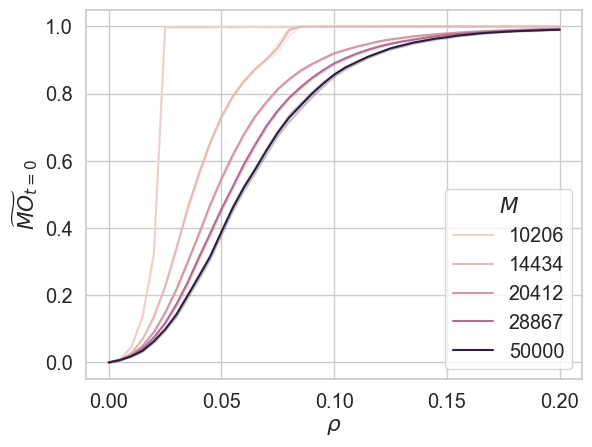

In [311]:
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm2_,x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$M$")

In [312]:
#N=20000
#lam=1
palette = sns.color_palette("viridis",8)[1:6]

In [313]:
datac0_[r"$\alpha$"] = (np.round(datac0_[r"$N$"]/datac0_[r"$M$"])).astype(int)
datac1_[r"$\alpha$"] = (np.round(datac1_[r"$N$"]/datac1_[r"$M$"])).astype(int)
datacm2_[r"$\alpha$"] = (np.round(datacm2_[r"$N$"]/datacm2_[r"$M$"])).astype(int)

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_3452/2486408874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacm2_[r"$\alpha$"] = (np.round(datacm2_[r"$N$"]/datacm2_[r"$M$"])).astype(int)


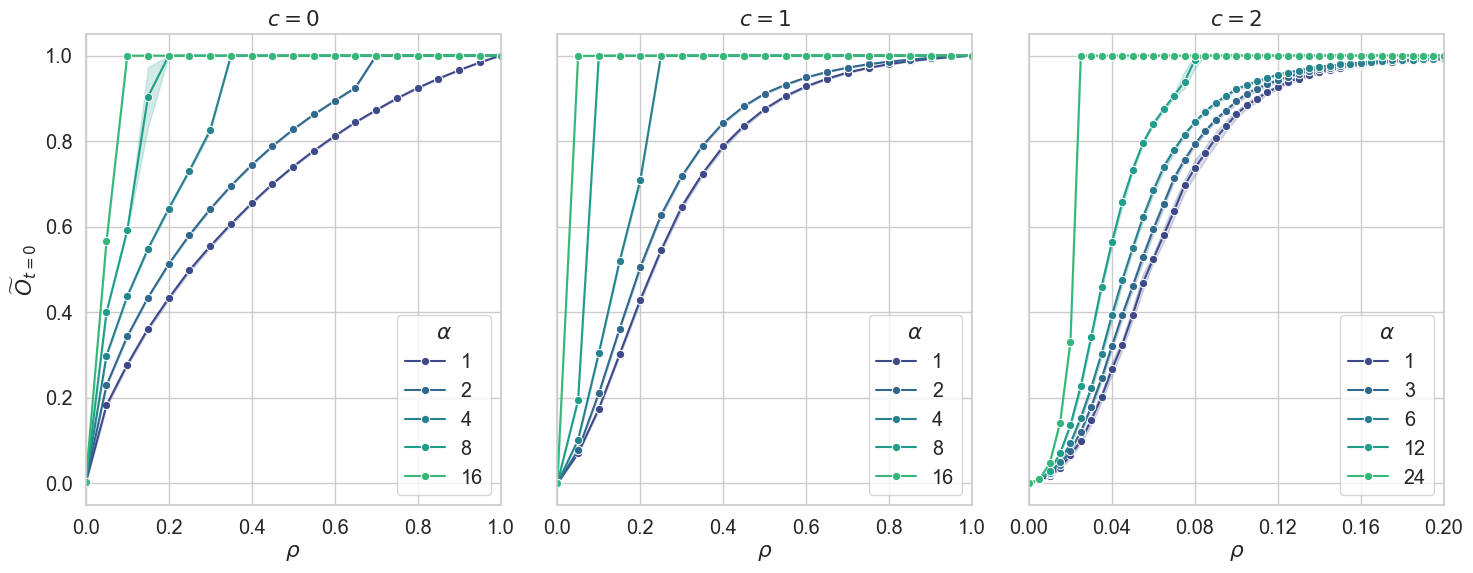

In [314]:
#Put all three previous plots side by side in a single figure
x_s= r"$\rho$"
y_s = "$\widetilde{MO}_{t=0}$"
y_s = r'$R_{SE}$'
y_s = "$\widetilde{O}_{t=0}$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.lineplot(data=datac0_,hue=hue_s,y=y_s, x=x_s, ax=axs[0],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datacm2_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),errorbar=("ci",99),marker="o",legend="full")
#sns.scatterplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),marker="o",s=20,edgecolor="black",linewidth=0.5)
axs[0].set_title(r"$c=0$")
axs[1].set_title(r"$c=1$")
axs[2].set_title(r"$c=2$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,0.2)
axs[2].set_xticks([0,0.04,0.08,0.12,0.16,0.2])
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/O_SI_Rademacher_omega_lam1.png",dpi=600)

In [ ]:
#y_s = '$MO_{t=0}$'
#y_s = 'MSE'
y_s = r'$R_{MSE}$'
y_s = r"$\widetilde{MO}_{t=0}$"

In [323]:
file_name = "DF_BP_1308.xz"
with lzma.open("./data_shared/"  + file_name, "rb") as f:
    data_frame_BP = pickle.load(f)

load_Dir = "./CLUSTER/DataCxtEpi/data_new/"
file_name = "DF_20250616-c2BP.xz"
with lzma.open(load_Dir  + file_name, "rb") as f:
    data_frame_BP2 = pickle.load(f)

In [324]:
data_frame_BP[r"$\rho$"] = data_frame_BP["M"]
data_frame_BP[r"$\delta$"] = data_frame_BP["S"]

data_frame_BP2[r"$\rho$"] = data_frame_BP2["M"]
data_frame_BP2[r"$\delta$"] = data_frame_BP2["S"]

In [ ]:
dataBPcm1 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.841345)& (data_frame_BP["init"] == "rnd")]
dataBPc0 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.5)& (data_frame_BP["init"] == "rnd")]
dataBPc1 = data_frame_BP[(data_frame_BP[r"$\delta$"] == 0.158655)& (data_frame_BP["init"] == "rnd")]

In [ ]:
dataBPcm2 = data_frame_BP2[(data_frame_BP2["init"] == "rnd")]
rho_list = np.sort(data_frame_BP[r"$\rho$"].unique())
rho_list2 = np.sort(data_frame_BP2[r"$\rho$"].unique())
rMO_m1 = np.zeros(len(rho_list))
rMO_0 = np.zeros(len(rho_list))
rMO_1 = np.zeros(len(rho_list))
rMO_2 = np.zeros(len(rho_list2))
for i,rho in enumerate(rho_list):
    rMO_m1[i] = dataBPcm1[dataBPcm1[r"$\rho$"] == rho][y_s].mean()
    rMO_0[i] = dataBPc0[dataBPc0[r"$\rho$"] == rho][y_s].mean()
    rMO_1[i] = dataBPc1[dataBPc1[r"$\rho$"] == rho][y_s].mean()
for i,rho in enumerate(rho_list2):
    rMO_2[i] = dataBPcm2[dataBPcm2[r"$\rho$"] == rho][y_s].mean()

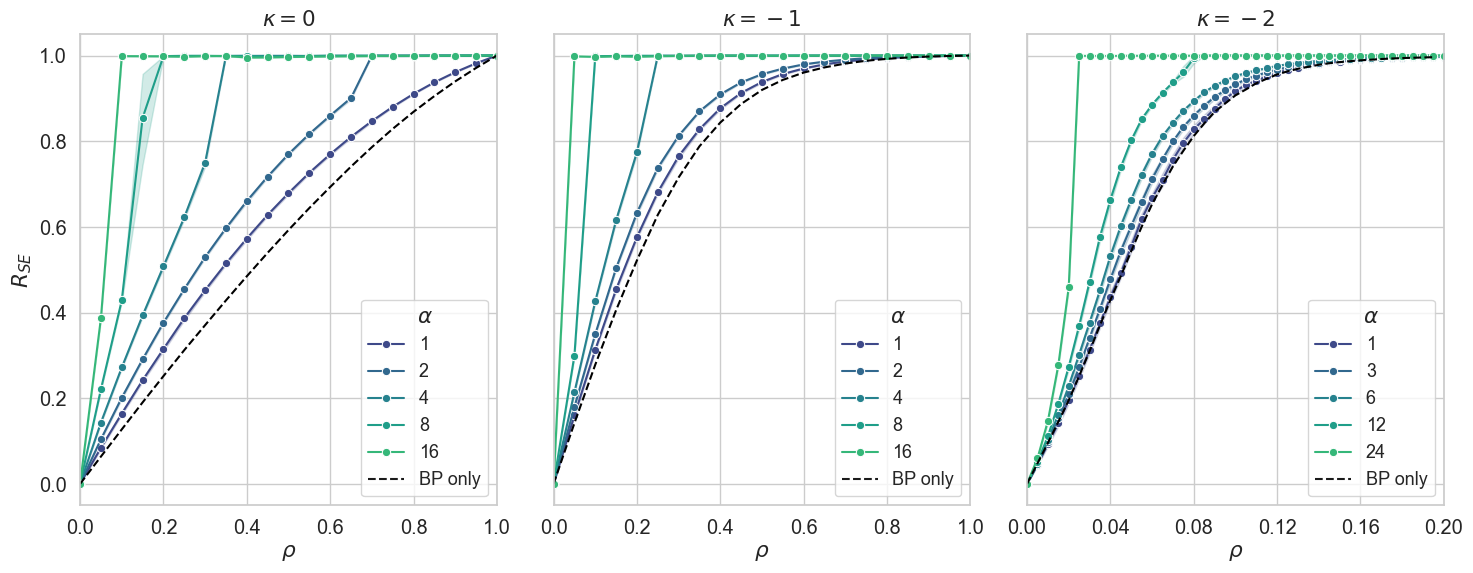

In [ ]:
#Add BP curves to the previous plot
x_s= r"$\rho$"
hue_s = r"$\alpha$"
y_s = "$\widetilde{O}_{t=0}$"
#y_s = r'$R_{SE}$'
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
#fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datac0_,hue=hue_s,y=y_s, x=x_s, ax=axs[0],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1_,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datacm2_,hue=hue_s,y=y_s, x=x_s, ax=axs[2],palette=sns.color_palette(palette, len(palette)),marker="o",errorbar=("ci",99),legend="full")
axs[0].set_title(r"$\kappa=0$")
axs[1].set_title(r"$\kappa=-1$")
axs[2].set_title(r"$\kappa=-2$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,0.2)
axs[0].plot(rho_list, rMO_0, color="black", linestyle="--")
axs[1].plot(rho_list, rMO_1, color="black", linestyle="--")
axs[2].plot(rho_list2, rMO_2, color="black", linestyle="--")
# Add second legend for BP curves without substituting the first legend
line_bp = Line2D([0], [0], label='BP only', color='k', linestyle='--')
handles, labels = axs[0].get_legend_handles_labels()
handles.append(line_bp)
labels.append('BP only')
axs[0].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

handles, labels = axs[1].get_legend_handles_labels()
handles.append(line_bp)
labels.append('BP only')
axs[1].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")

handles, labels = axs[2].get_legend_handles_labels()
handles.append(line_bp)
labels.append('BP only')
axs[2].legend(handles, labels, loc='lower right', fontsize='small', title=r"$\alpha$")
axs[2].set_xticks([0,0.04,0.08,0.12,0.16,0.2])
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/O_SI_Rademacher_k2_BP.pdf")#,dpi=600)

In [ ]:
y_s = "$\widetilde{\delta O}_{t=0}$"
y_s = '$\delta R_{SE}$'

In [156]:
df = datacm2_[(datacm2_[r"$\widetilde{MO}_{t=0}$"] - datacm2_[r"$\widetilde{O}_{t=0}$"]) <0.0002]

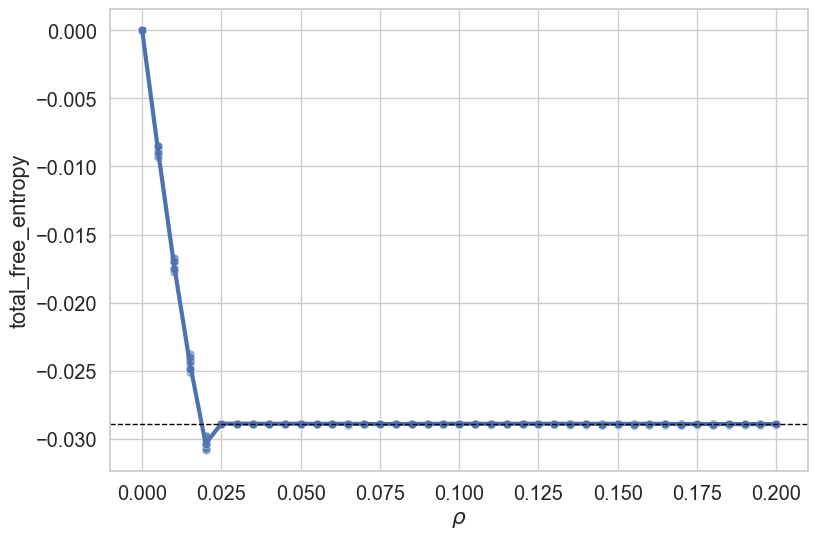

In [163]:
y_s = "total_free_entropy"
fig, ax = plt.subplots(1, 1, figsize=(9,6))
sns.scatterplot(data=df[df[r"$\alpha$"]==24],x=r"$\rho$",y=y_s, alpha=0.6, s=40)
sns.lineplot(data=df[df[r"$\alpha$"]==24],x=r"$\rho$",y=y_s, errorbar=None, linewidth=3)
ax.axhline(y=-np.log(2)/24, color='black', linestyle='--', linewidth=1)

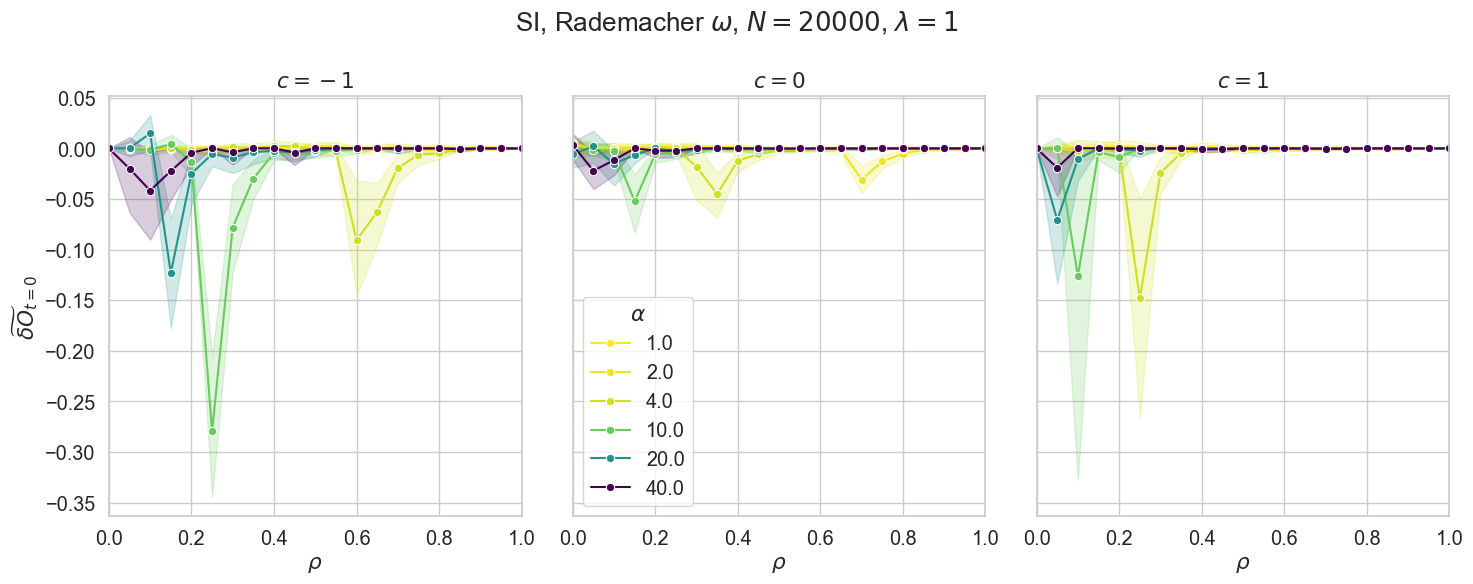

In [ ]:
x_s= r"$\rho$"
hue_s = r"$\alpha$"
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1,hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0,hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")
sns.lineplot(data=datac1,hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/Nishi_SE_SI_Rademacher_N{N}_lam{lam}.png",dpi=600)

In [ ]:
datacm1tot = data_frame_tot[(data_frame_tot["c"] == -1) & (data_frame_tot[r"$\alpha$"] < 50)]
datac0tot = data_frame_tot[(data_frame_tot["c"] == 0) & (data_frame_tot[r"$\alpha$"] < 50)]
datac1tot = data_frame_tot[(data_frame_tot["c"] == 1) & (data_frame_tot[r"$\alpha$"] < 50)]

In [ ]:
alpha = 10
y_s = "$\widetilde{O}_{t=0}$"
y_s = r'$R_{SE}$'

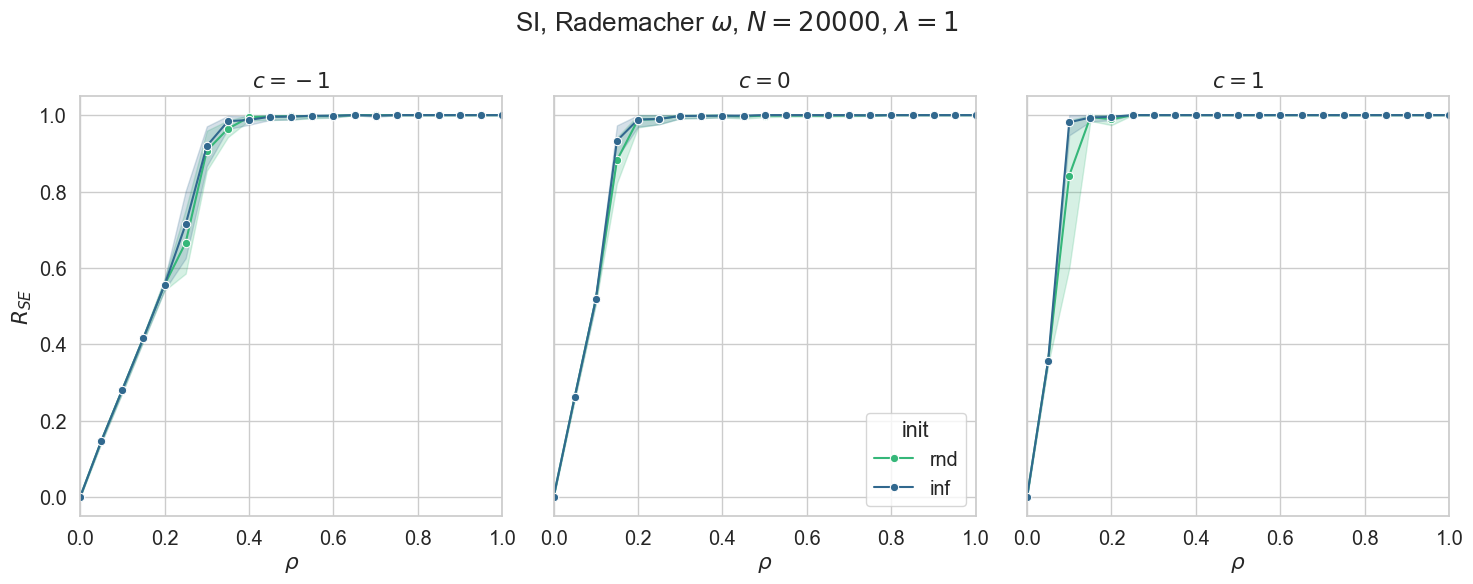

In [ ]:
x_s= r"$\rho$"
hue_s = "init"

fig, axs = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=datacm1tot[datacm1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[0],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
sns.lineplot(data=datac0tot[datac0tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[1],palette="viridis_r",marker="o",errorbar=("ci",99),legend="full")   
sns.lineplot(data=datac1tot[datac1tot[r"$\alpha$"] == alpha],hue=hue_s,y=y_s, x=x_s, ax=axs[2],legend=False,palette="viridis_r",marker="o",errorbar=("ci",99))
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
              
plt.tight_layout()
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

## Plot zoom

### Single plot

In [26]:
#file_name = "DF_20240919-170509_873.xz"
load_Dir = "./CLUSTER/DataCxtEpi/data_new/" 
file_name = "DF_20241127-100437_241.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [27]:
data_frame_tot.iloc[:,55:65]

$\delta SE$  $R_{SE}$  $R_{MSE}$  $\delta R_{SE}$  \
0      -0.000788  0.998415   0.996335         0.002080   
1       0.014869  0.958710   0.997970        -0.039260   
2      -0.000699  0.998778   0.996913         0.001865   
3      -0.002676  0.995800   0.988659         0.007141   
4      -0.000347  0.999258   0.998321         0.000936   
..           ...       ...        ...              ...   
753    -0.001373  0.997494   0.993808         0.003686   
754    -0.000316  0.998932   0.998098         0.000834   
755    -0.000900  0.998273   0.995897         0.002377   
756     0.079305  0.783133   0.995152        -0.212019   
757     0.080219  0.781628   0.996061        -0.214434   

                                            ConvChecks  
0    [[10, 0.032529959216811635, 5.734502659838834e...  
1    [[10, 0.012893023089167392, 6.521777105116823e...  
2    [[8, 0.04205089450057087, 1.3646908441253264e-...  
3    [[8, 0.07694334081930299, 5.077601197144016e-07]]  
4    [[10, 0.020621535349724995, 3.602331358678353e...  
..                                                 ...  
753  [[8, 0.05727499989876861, 2.9545053896752625e-...  
754  [[7, 0.0648387924106022, 1.2206487706175622e-07]]  
755  [[7, 0.028837259365601997, 1.8869117572375146e...  
756  [[9, 0.06326011669847524, 5.793750456340162e-07]]  
757  [[10, 0.046408140139808735, 7.294134354772767e...  

[758 rows x 5 columns]

In [28]:
data_frame_tot[data_frame_tot["iteration"]>2499].iloc[:,15:35]

T_max mask_type  $\mu$   tol2  it_max  $T$  $f_S$  $f_I$  $T_O$  \
32     500        SI      0  0.001    2500    3    0.0    1.0      3   
79     500        SI      0  0.001    2500    3    0.0    1.0      3   
80     500        SI      0  0.001    2500    3    0.0    1.0      3   
98     500        SI      0  0.001    2500    3    0.0    1.0      3   
99     500        SI      0  0.001    2500    3    0.0    1.0      3   
130    500        SI      0  0.001    2500    3    0.0    1.0      3   
172    500        SI      0  0.001    2500    3    0.0    1.0      3   
182    500        SI      0  0.001    2500    3    0.0    1.0      3   
188    500        SI      0  0.001    2500    3    0.0    1.0      3   
195    500        SI      0  0.001    2500    3    0.0    1.0      3   
223    500        SI      0  0.001    2500    3    0.0    1.0      3   
229    500        SI      0  0.001    2500    3    0.0    1.0      3   
246    500        SI      0  0.001    2500    3    0.0    1.0      3   
247    500        SI      0  0.001    2500    3    0.0    1.0      3   
250    500        SI      0  0.001    2500    3    0.0    1.0      3   
271    500        SI      0  0.001    2500    3    0.0    1.0      3   
285    500        SI      0  0.001    2500    3    0.0    1.0      3   
343    500        SI      0  0.001    2500    3    0.0    1.0      3   
353    500        SI      0  0.001    2500    3    0.0    1.0      3   
366    500        SI      0  0.001    2500    3    0.0    1.0      3   
373    500        SI      0  0.001    2500    3    0.0    1.0      3   
382    500        SI      0  0.001    2500    3    0.0    1.0      3   
383    500        SI      0  0.001    2500    3    0.0    1.0      3   
437    500        SI      0  0.001    2500    3    0.0    1.0      3   
445    500        SI      0  0.001    2500    3    0.0    1.0      3   
495    500        SI      0  0.001    2500    3    0.0    1.0      3   
500    500        SI      0  0.001    2500    3    0.0    1.0      3   
526    500        SI      0  0.001    2500    3    0.0    1.0      3   
543    500        SI      0  0.001    2500    3    0.0    1.0      3   
593    500        SI      0  0.001    2500    3    0.0    1.0      3   
600    500        SI      0  0.001    2500    3    0.0    1.0      3   
610    500        SI      0  0.001    2500    3    0.0    1.0      3   
662    500        SI      0  0.001    2500    3    0.0    1.0      3   
686    500        SI      0  0.001    2500    3    0.0    1.0      3   
706    500        SI      0  0.001    2500    3    0.0    1.0      3   
729    500        SI      0  0.001    2500    3    0.0    1.0      3   
742    500        SI      0  0.001    2500    3    0.0    1.0      3   
748    500        SI      0  0.001    2500    3    0.0    1.0      3   

     $T_{BP}$  $infer_up_to$  $\Delta$  damping    c   $M$  uRad  \
32          3             -1       501      0.4  0.0  2000  True   
79          3             -1       501      0.4  0.0  2000  True   
80          3             -1       501      0.4  0.0  2000  True   
98          3             -1       501      0.4  0.0  2000  True   
99          3             -1       501      0.4  0.0  2000  True   
130         3             -1       501      0.4  0.0  2000  True   
172         3             -1       501      0.4  0.0  2000  True   
182         3             -1       501      0.4  0.0  2000  True   
188         3             -1       501      0.4  0.0  2000  True   
195         3             -1       501      0.4  0.0  2000  True   
223         3             -1       501      0.4  0.0  2000  True   
229         3             -1       501      0.4  0.0  2000  True   
246         3             -1       501      0.4  0.0  2000  True   
247         3             -1       501      0.4  0.0  2000  True   
250         3             -1       501      0.4  0.0  2000  True   
271         3             -1       501      0.4  0.0  2000  True   
285         3             -1       501  

In [29]:
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]
data_frame_tot[r"$\alpha$"] = data_frame_tot[r"$N$"]/data_frame_tot[r"$M$"]

In [30]:
data_frame_conv = data_frame_tot[data_frame_tot["iteration"]<2499]

In [31]:
#o_list = data_frame_tot[data_frame_tot["$\widetilde{MO}_{t=0}$"]>1-1e-3]["$\widetilde{O}_{t=0}$"]
#it_list = data_frame_tot[data_frame_tot["$\widetilde{MO}_{t=0}$"]>1-1e-3]["iteration"]
#for i in range(len(o_list)):
#    print(f"o={o_list.iloc[i]} at iteration {it_list.iloc[i]}")

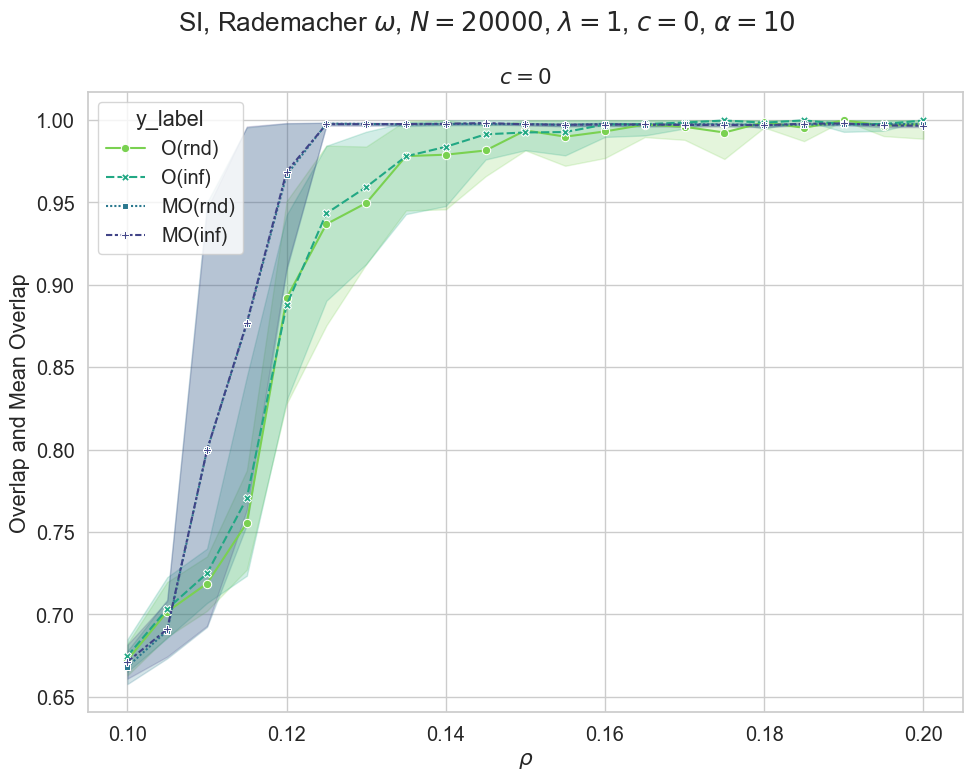

In [36]:
c=0
alpha=10
data_frame_t = data_frame_conv[data_frame_conv[r"$\alpha$"]==alpha]
data_frame_t = data_frame_t[data_frame_t["c"]==c]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
#df1["y"] = df1["$O_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
#df2["y"] = df2["$MO_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df = pd.concat([df1,df2],ignore_index=True)
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$, $c={c}$, $\\alpha={alpha}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",errorbar=("ci",99),legend="full", style="y_label", markers=True)
#sns.scatterplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",legend="full", style="y_label", markers=True)
ax.set_title(f"$c={c}$")
#ax.set_xlim(0.6,0.7)
              
plt.tight_layout()
plt.ylabel(r"Overlap and Mean Overlap")
#plt.legend(title="Initialization")
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

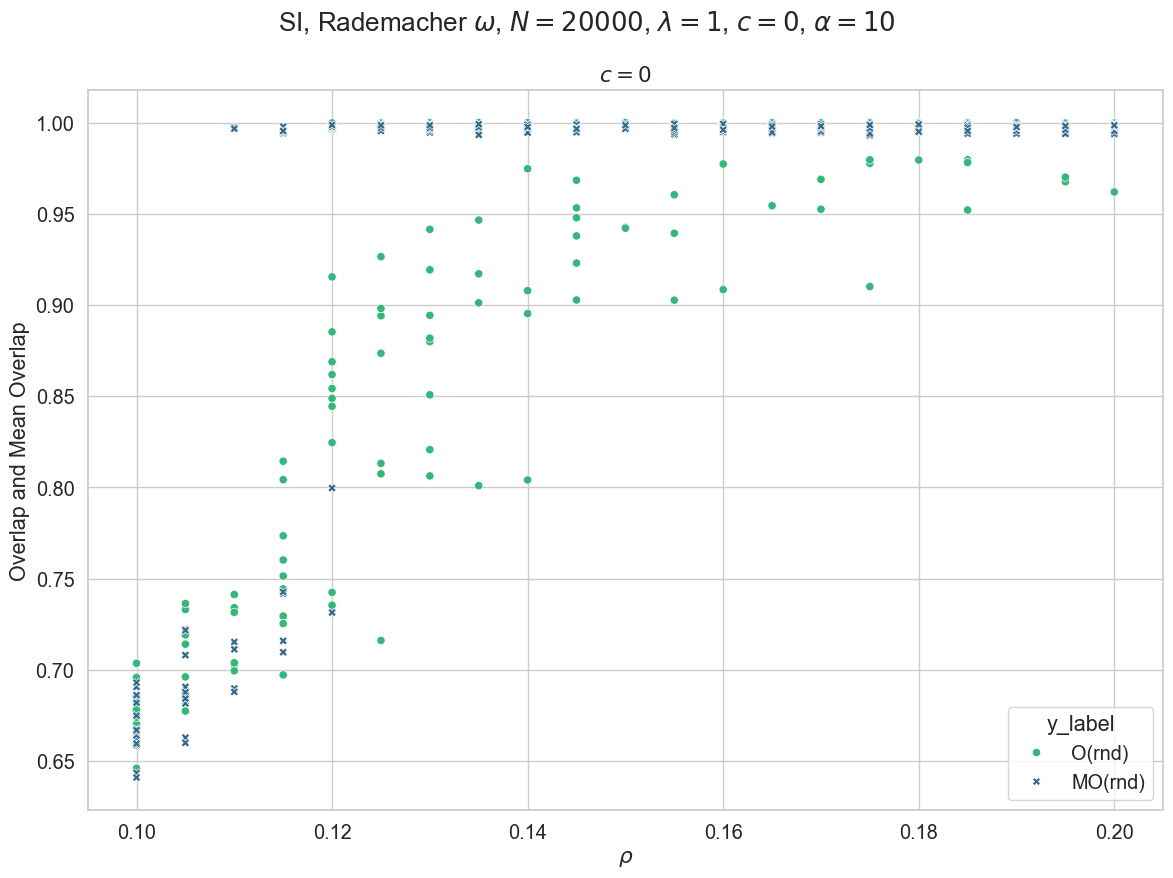

In [37]:
c=0
alpha=10
data_frame_t = data_frame_conv[(data_frame_conv[r"$\alpha$"]==alpha) & (data_frame_conv["init"]=="rnd")]
data_frame_t = data_frame_t[data_frame_t["c"]==c]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
#df1["y"] = df1["$O_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
#df2["y"] = df2["$MO_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df = pd.concat([df1,df2],ignore_index=True)
fig, ax = plt.subplots(1, 1, figsize=(12,9), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$, $c={c}$, $\\alpha={alpha}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
#sns.boxplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",legend="full")
sns.scatterplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",legend="full", style="y_label", markers=True)
ax.set_title(f"$c={c}$")
#ax.set_xlim(0.6,0.7)
              
plt.tight_layout()
plt.ylabel(r"Overlap and Mean Overlap")
#plt.legend(title="Initialization")
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

In [ ]:
c=0
alpha=10
data_frame_t = data_frame_conv[data_frame_conv[r"$\alpha$"]==alpha]
data_frame_t = data_frame_t[data_frame_t["c"]==c]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df = pd.concat([df1,df2],ignore_index=True)
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$, $c={c}$, $\\alpha={alpha}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",errorbar=("ci",99),legend="full", style="y_label", markers=True)
#sns.scatterplot(data=df,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",legend="full", style="y_label", markers=True)
ax.set_title(f"$c={c}$")
#ax.set_xlim(0.6,0.7)
              
plt.tight_layout()
plt.ylabel(r"Overlap and Mean Overlap")
#plt.legend(title="Initialization")
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

### All plots

In [1]:
file_name = "DF_20241011-114041_682.xz"
#file_name = "DF_zoom_allc.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

NameError: name 'lzma' is not defined

In [16]:
5 | 2 | 1

7

In [5]:
data_frame_tot.iloc[:,0:5]

init graph_type    $N$  $d$  $\lambda$
0      rnd        rrg  20000    3        1.0
1      inf        rrg  20000    3        1.0
2      rnd        rrg  20000    3        1.0
3      inf        rrg  20000    3        1.0
4      rnd        rrg  20000    3        1.0
...    ...        ...    ...  ...        ...
10061  inf        rrg  20000    3        1.0
10062  rnd        rrg  20000    3        1.0
10063  inf        rrg  20000    3        1.0
10064  rnd        rrg  20000    3        1.0
10065  inf        rrg  20000    3        1.0

[10066 rows x 5 columns]

In [17]:
data_frame_tot[data_frame_tot["iteration"]>2499].iloc[:,5:15]

s_type    S o_type      M  iter_space  seed       tol  n_iter obs_type  \
1      delta  0.5    rho  0.260         100     1  0.000001     100  sensors   
3      delta  0.5    rho  0.260         100    16  0.000001     100  sensors   
4      delta  0.5    rho  0.285         100    16  0.000001     100  sensors   
10     delta  0.5    rho  0.290         100    13  0.000001     100  sensors   
11     delta  0.5    rho  0.290         100    13  0.000001     100  sensors   
...      ...  ...    ...    ...         ...   ...       ...     ...      ...   
10037  delta  0.5    rho  0.135         100    19  0.000001     100  sensors   
10042  delta  0.5    rho  0.090         100    15  0.000001     100  sensors   
10048  delta  0.5    rho  0.110         100    17  0.000001     100  sensors   
10061  delta  0.5    rho  0.125         100    13  0.000001     100  sensors   
10062  delta  0.5    rho  0.110         100     8  0.000001     100  sensors   

       snap_time  
1             -1  
3             -1  
4             -1  
10            -1  
11            -1  
...          ...  
10037         -1  
10042         -1  
10048         -1  
10061         -1  
10062         -1  

[1823 rows x 10 columns]

In [18]:
data_frame_tot = data_frame_tot[data_frame_tot["iteration"]<2499]

In [19]:
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]
data_frame_tot[r"$\alpha$"] = data_frame_tot[r"$N$"]/data_frame_tot[r"$M$"]

In [20]:
N=20000
lam=1

alpha=10
data_frame_t = data_frame_tot[data_frame_tot[r"$\alpha$"]==alpha]

In [21]:
c=1
data_frame_t = data_frame_tot[data_frame_tot[r"$\alpha$"]==alpha]
data_frame_t = data_frame_t[data_frame_t["c"]==c]
if (alpha == 4 & c == -1): 
    data_frame_t = data_frame_t[data_frame_t[r"$\rho$"]>0.5]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df_c1 = pd.concat([df1,df2],ignore_index=True)

c=0
data_frame_t = data_frame_tot[data_frame_tot[r"$\alpha$"]==alpha]
data_frame_t = data_frame_t[data_frame_t["c"]==c]
if (alpha == 4 & c == -1): 
    data_frame_t = data_frame_t[data_frame_t[r"$\rho$"]>0.5]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df_c0 = pd.concat([df1,df2],ignore_index=True)

c=-1
data_frame_t = data_frame_tot[data_frame_tot[r"$\alpha$"]==alpha]
data_frame_t = data_frame_t[data_frame_t["c"]==c]
if (alpha == 4 & c == -1): 
    data_frame_t = data_frame_t[data_frame_t[r"$\rho$"]>0.5]

df1 = data_frame_t[data_frame_t["c"]==c]
df1["y"] = df1["$\widetilde{O}_{t=0}$"]
df1["y_label"] = "O(" + df1["init"] + ")"
df2 = data_frame_t[data_frame_t["c"]==c]
df2["y"] = df2["$\widetilde{MO}_{t=0}$"]
df2["y_label"] = "MO(" + df2["init"] + ")"
df_cm1 = pd.concat([df1,df2],ignore_index=True)

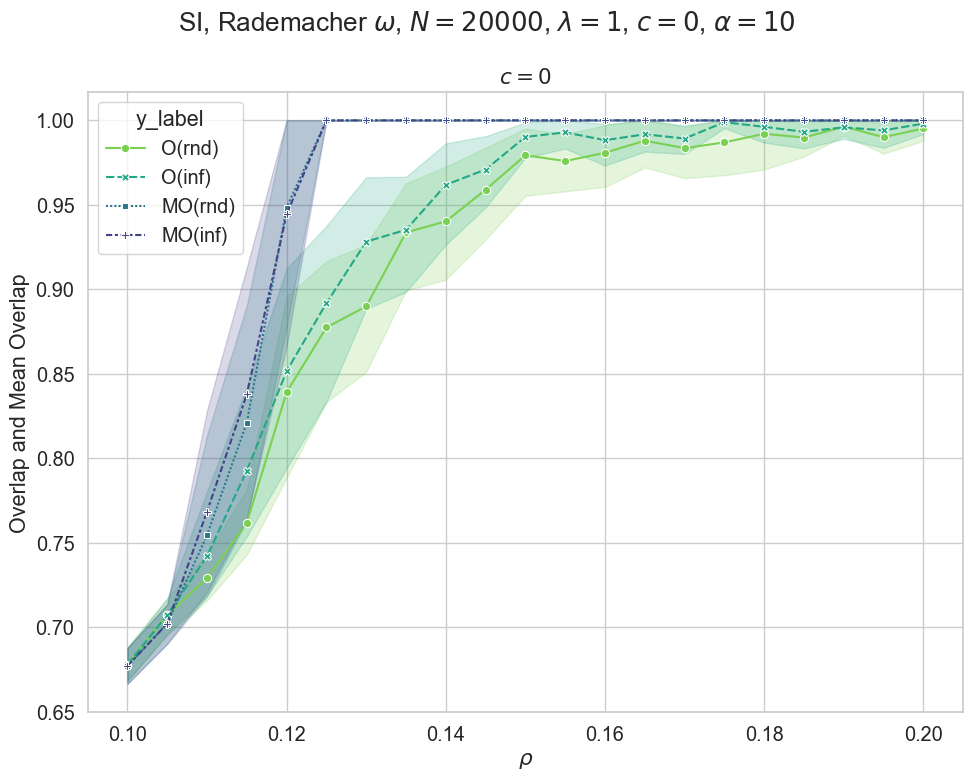

In [32]:
c=0
fig, ax = plt.subplots(1, 1, figsize=(10,8), sharey=True)
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$, $c={c}$, $\\alpha={alpha}$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=df_c0,y="y",hue="y_label", x=r"$\rho$", ax=ax,palette="viridis_r",errorbar=("ci",99),legend="full", style="y_label", markers=True)
ax.set_title(f"$c={c}$")
#ax.set_xlim(0.6,0.7)
              
plt.tight_layout()
plt.ylabel(r"Overlap and Mean Overlap")
#plt.legend(title="Initialization")
plt.show()
#fig.savefig(f"./figures/MSE_SI_Gaussian_omega_N{N}_lam{lam}_BP.pdf")

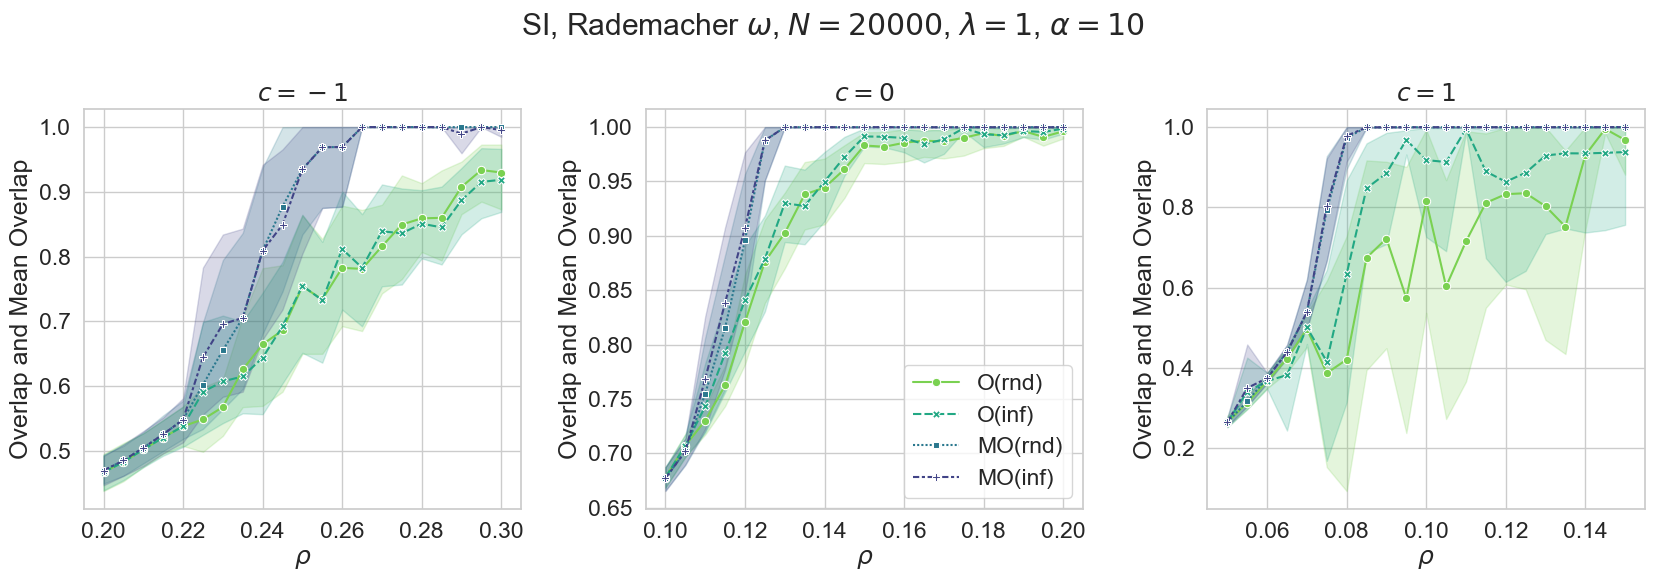

In [241]:
fig, axs = plt.subplots(1, 3, figsize=(17,6))
fig.suptitle(f"SI, Rademacher $\omega$, $N={N}$, $\lambda={lam}$, $\\alpha={alpha}$")
sns.set_theme(style="whitegrid",font_scale=1.5)
sns.lineplot(data=df_cm1,y="y", x=r"$\rho$",hue="y_label", ax=axs[0],palette="viridis_r",errorbar=("ci",99),legend=False, style="y_label", markers=True)
sns.lineplot(data=df_c0,y="y", x=r"$\rho$",hue="y_label", ax=axs[1],palette="viridis_r",errorbar=("ci",99),legend="full", style="y_label", markers=True)
sns.lineplot(data=df_c1,y="y", x=r"$\rho$",hue="y_label", ax=axs[2],palette="viridis_r",errorbar=("ci",99),legend=False, style="y_label", markers=True)
axs[0].set_title(r"$c=-1$")
axs[1].set_title(r"$c=0$")
axs[2].set_title(r"$c=1$")
axs[1].legend(title="")
axs[0].set_ylabel(r"Overlap and Mean Overlap")
axs[1].set_ylabel(r"Overlap and Mean Overlap")
axs[2].set_ylabel(r"Overlap and Mean Overlap")
plt.tight_layout()
fig.savefig(f"./figures/Zoom_insances.pdf")

# Log Likelihood

In [23]:
file_name = "DF_20250407-114148_152.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame = pickle.load(f)

In [24]:
data_frame[r"$\rho$"] = data_frame["M"]
data_frame[r"$\alpha$"] = data_frame[r"$N$"]/data_frame[r"$M$"]

In [25]:
data_frame.iloc[:,30:45]

uRad         error  iteration  it_final      logL  $O_{t=0}$  \
0    False  7.299562e-07          8         8 -0.363106    0.88930   
1    False  1.237072e-17         12        12 -0.050572    1.00000   
2    False  3.595377e-07         12        12 -0.049709    0.99535   
3    False  5.037544e-07         12        12 -0.034292    0.81775   
4    False  3.487427e-07          6         6 -0.147981    0.70475   
..     ...           ...        ...       ...       ...        ...   
675  False  9.897367e-07          9         9 -0.442594    0.94710   
676  False  4.506577e-07          7         7 -0.270310    0.81195   
677  False  7.030445e-07          8         8 -0.393245    0.91590   
678  False  2.040122e-07         14        14 -0.049920    0.98635   
679  False  4.018510e-07         16        16 -0.044345    0.89370   

     $O_{t=0,RND}$  $MO_{t=0}$  $MO_{t=0,RND}$  $\delta O_{t=0}$  \
0          0.50030    0.891400        0.501829         -0.002100   
1          0.50255    1.000000        0.502550          0.000000   
2          0.50195    0.995533        0.502030         -0.000183   
3          0.50135    0.812496        0.501902          0.005254   
4          0.50105    0.704772        0.502759         -0.000022   
..             ...         ...             ...               ...   
675        0.50270    0.946850        0.503801          0.000250   
676        0.50625    0.812566        0.500771         -0.000616   
677        0.50060    0.911590        0.500023          0.004310   
678        0.50195    0.984814        0.501245          0.001536   
679        0.50160    0.890688        0.501221          0.003012   

     $\widetilde{O}_{t=0}$  $\widetilde{MO}_{t=0}$  \
0                 0.778467                0.782003   
1                 1.000000                1.000000   
2                 0.990664                0.991030   
3                 0.634513                0.623559   
4                 0.408257                0.406269   
..                     ...                     ...   
675               0.893626                0.892886   
676               0.619139                0.624552   
677               0.831598                0.823172   
678               0.972593                0.969553   
679               0.786717                0.780841   

     $\widetilde{\delta O}_{t=0}$  $O_{t=T}$  $O_{t=T,RND}$  
0                       -0.003536        1.0            1.0  
1                        0.000000        1.0            1.0  
2                       -0.000367        1.0            1.0  
3                        0.010954        1.0            1.0  
4                        0.001988        1.0            1.0  
..                            ...        ...            ...  
675                      0.000740        1.0            1.0  
676                     -0.005413        1.0            1.0  
677                      0.008426        1.0            1.0  
678                      0.003040        1.0            1.0  
679                      0.005876        1.0            1.0  

[680 rows x 15 columns]

<Axes: xlabel='$\\rho$', ylabel='$\\widetilde{O}_{t=0}$'>

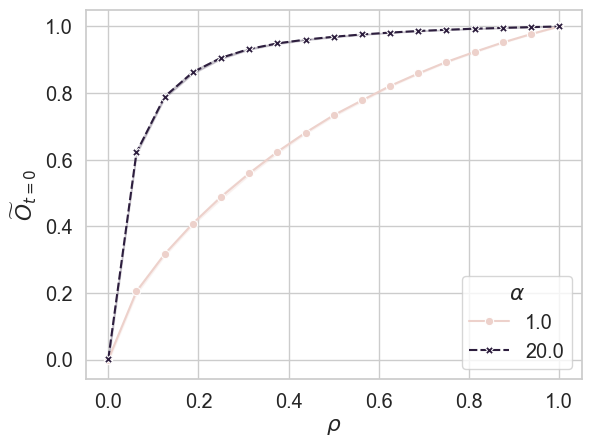

In [29]:
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=data_frame,x=r"$\rho$",y=r"$\widetilde{O}_{t=0}$", hue=r"$\alpha$", markers=True, errorbar=("ci",99), style=r"$\alpha$")

In [32]:
alpha_list = data_frame[r"$\alpha$"].unique()

In [33]:
logZ_inf_list = np.zeros(len(alpha_list))
for i, alpha in enumerate(alpha_list):
    logZ_inf_list[i] = data_frame[(data_frame[r"$\rho$"]==1) & (data_frame[r"$\alpha$"]==alpha)]["total_free_entropy"].mean()

In [34]:
logZ_inf_list

array([-0.59654226, -0.15819985])

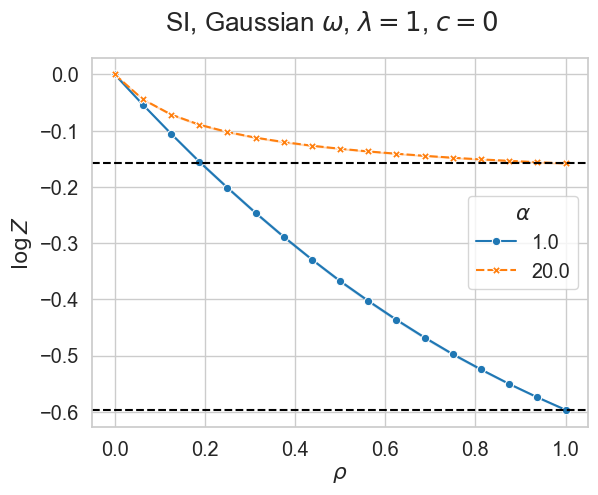

In [44]:
plt.suptitle(f"SI, Gaussian $\omega$, $\lambda=1$, $c=0$")
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=data_frame,x=r"$\rho$",y="total_free_entropy", hue=r"$\alpha$", markers=True, errorbar=("ci",99), style=r"$\alpha$", palette="tab10")
plt.axhline(y=logZ_inf_list[0], color="black", linestyle="--")
plt.axhline(y=logZ_inf_list[1], color="black", linestyle="--")
plt.ylabel(r"$\log Z$")
plt.savefig(f"./figures/logZ_gauss_c0.pdf")